In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import requests
import os
import time
import random

def set_seed(seed):
    # 1. Basic Python and OS seeding
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # 2. NumPy seeding
    np.random.seed(seed)

    # 3. PyTorch CPU seeding
    torch.manual_seed(seed)

    # 4. PyTorch GPU seeding (if using CUDA)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # For multi-GPU setups

    # 5. Essential for deterministic algorithms (The "Hard" Part)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ========================================
# GENERAL CONFIGS
# ========================================
set_seed(123)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 64
TIME_WINDOW_SIZE = 128
LR = 5e-3   # INITIALLY, WE DO SOME COOLING AFTER A FEW STEPS
EVAL_INTERVAL = 100
# ==========================================
# 0. CONFIGURATION FOR BASE
# ==========================================

N_SOFITS = 2048
BLOCK_DIM = 128     # 2048 / 32 = 64 local neighborhoods
SHORTCUT_RANK = 64 # bits -> 64 -> bits
DROPOUT = 0.2
FILENAME = 'sofistron_base.cpt'

# Data Loading Deterministic
url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
if not os.path.exists('input.txt'):
    data_str = requests.get(url).text
    with open('input.txt', 'w') as f: f.write(data_str)
else:
    with open('input.txt', 'r') as f: data_str = f.read()

chars = sorted(list(set(data_str)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(data_str), dtype=torch.long)
n_split = int(0.9*len(data))
train_data = data[:n_split]
val_data = data[n_split:]

# ============================================================
# 1. TOPOLOGY (Local + Circular Block + Holographic)
# ===========================================================
class Topology(nn.Module):
    def __init__(self, n_sofits, block_dim, short_cut_rnk):
        super().__init__()
        self.n_sofits = n_sofits
        self.block_dim = block_dim
        self.num_blocks = n_sofits // block_dim

        # Local Neighborhoods (Dense Blocks)
        self.local_weights = nn.Parameter(torch.randn(self.num_blocks, block_dim, block_dim) * 0.05)
        # Global Shortcuts (Low-Rank / P-Rewire equivalent)
        self.shortcut_down = nn.Parameter(torch.randn(n_sofits, short_cut_rnk) * 0.02)
        self.shortcut_up = nn.Parameter(torch.randn(short_cut_rnk, n_sofits) * 0.02)

        # A balanced mix that sums > 1.0 with sum**2 = 0.92 (energy damping), this needs deep dive study!
        self.alpha = 0.92   # Local (The "Forget Gate" - keeps 92% of history)
        self.beta  = 0.20   # Shift (Short-term context update)
        self.gamma = 0.15   # Jump  (Long-term teleportation)

    def forward(self, h):
        B, N = h.shape
        # 1. Neighborhood Processing (O(N) Parameter efficiency)
        h_blocked = h.view(B, self.num_blocks, self.block_dim).transpose(0, 1) # (Groups, B, BS)
        h_local = torch.bmm(h_blocked, self.local_weights)
        h_local = h_local.transpose(0, 1).contiguous().view(B, N)

        # 2. Small-World Circular Coupling
        h_shifted = torch.roll(h, shifts=self.block_dim, dims=1)

        # 3. Global Holographic Jumps
        h_jump = h @ self.shortcut_down @ self.shortcut_up

        return self.alpha*h_local + self.beta*h_shifted + self.gamma*h_jump

# ==========================================
# 2. BICAMERAL GATING:
# First: Sofit sees x(reality) + h(history/secret info)
# Second Decoding/Translation of info base on reality: Sofit produces a 'tip' for both the next partner and for its own final commit -> First logic gate
# Third: Commit given what I know, the history and what I see: what do I say to my boss? -> second logic gate
# The sofit is already doing 2-boolean sofit operations in recursive order!! Each sofit thinks!! That is where thinking happens in this model
# ==========================================
class FusedSpectralGate(nn.Module):
    def __init__(self, n_sofits,init_scale=0.1):
        super().__init__()
        # Parallel parameters for Memory (Think/Decode) and Emission (Speak/Commit)
        #self.w_mem = nn.Parameter(torch.randn(4, n_sofits) * 0.05) # leave it here just in case, uniform seems to derive nicer coefficients, though this needs to be optimized
        #self.w_out = nn.Parameter(torch.randn(4, n_sofits) * 0.05)
        #self.nu = 4./3 # magic nu, though even a 0 nu seems to be working, and learned nus are even possible

        # Shape: (4, n_sofits) for the 4 basis terms
        # 1. Create empty parameters
        self.w_mem = nn.Parameter(torch.empty(4, n_sofits))
        self.w_out = nn.Parameter(torch.empty(4, n_sofits))

        # 2. Initialize Uniformly in [-1, 1] * scale
        # .uniform_(a, b) fills the tensor in-place
        self.w_mem.data.uniform_(-1, 1) * init_scale
        self.w_out.data.uniform_(-1, 1) * init_scale

    #def spectral_transform(self, z): Maybe useful for some things like quantization, but for now it is more elegant without enforcing strict -1, 1 behaviour
        # Spectral Logic # Intra Sofit Physics kicking in to stabilize/regularize/synchronize?
        #z_c = torch.clamp(z, -1.5, 1.5) # Make sure extreme low probs do not kill one long run with extreme sampling!
        #return z + (self.nu / 4.0) * z_c * (1 - z_c**2)

    def forward(self, h_context, x):
        # Note: We use ones_like(h) to match batch/sequence shape
        ones = torch.ones_like(h_context)
        # Memory Update (Gate 1)
        m_parts = torch.stack([
             h_context * x,
            (h_context + x) * 0.5,
            (h_context - x) * 0.5,
            ones
        ], dim=1)
        z_mem = torch.sum(m_parts * self.w_mem.unsqueeze(0), dim=1)
        h_next = z_mem #self.spectral_transform(z_mem)

        # Output Emission (Stabilized Bridge)
        # Commit Update (Gate 2)
        m_parts_2 = torch.stack([
             h_next * x,
            (h_next + x) * 0.5,
            (h_next - x) * 0.5,
            ones
        ], dim=1)
        z_out = torch.sum(m_parts_2 * self.w_out.unsqueeze(0), dim=1)
        y_emit = z_out #self.spectral_transform(z_out)

        return h_next, y_emit

# ==========================================
# 3. THE SofisTron
# ==========================================
class SofisTron(nn.Module):
    def __init__(self, vocab_size, n_sofits, block_dim, short_cut_rnk, dropout):
        super().__init__()
        self.n_sofits = n_sofits
        self.embed = nn.Embedding(vocab_size, n_sofits)
        self.topology = Topology(n_sofits, block_dim, short_cut_rnk)
        self.gate = FusedSpectralGate(n_sofits)
        self.head = nn.Linear(n_sofits, vocab_size, bias=False) # Boss informing how to behave next
        self.dropout = nn.Dropout(dropout)  # Define dropout layer

    def forward(self, idx, targets=None):
        B, T = idx.shape
        h = torch.zeros(B, self.n_sofits, device=idx.device)
        outputs = []

        # Sequential thought loop
        for t in range(T):
            x = self.embed(idx[:, t])
            h_context = self.dropout(self.topology(h)) # 1st dropout
            h, y_emit = self.gate(h_context, x)
            outputs.append(y_emit)

        logits = self.head(self.dropout(torch.stack(outputs, dim=1))) # 2nd dropout
        loss = F.cross_entropy(logits.view(-1, vocab_size), targets.view(-1)) if targets is not None else None
        return logits, loss

In [2]:
def get_batch(split):
    d = train_data if split == 'train' else val_data
    ix = torch.randint(len(d) - TIME_WINDOW_SIZE, (BATCH_SIZE,))
    x = torch.stack([d[i:i+TIME_WINDOW_SIZE] for i in ix])
    y = torch.stack([d[i+1:i+TIME_WINDOW_SIZE+1] for i in ix])
    return x.to(DEVICE), y.to(DEVICE)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(10)
        for k in range(10):
            X, Y = get_batch(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [3]:
# ==========================================
# 4. TRAINING LOOP
# ==========================================
model = SofisTron(vocab_size=vocab_size, n_sofits=N_SOFITS, block_dim=BLOCK_DIM, short_cut_rnk=SHORTCUT_RANK, dropout=DROPOUT).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

In [ ]:
print(f"=== STARTING TRAIN ===")
print(f"Neighborhoods: {N_SOFITS//BLOCK_DIM} | Params: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

start_time = time.time()
for iter in range(1000*3):
    if iter % EVAL_INTERVAL == 0:
        losses = estimate_loss()
        dt = time.time() - start_time
        print(f"Step {iter} | Train: {losses['train']:.4f} | Val: {losses['val']:.4f} | Time: {dt:.1f}s")
        if losses["val"] < 1.47:
          break
    if iter == 1200:
        for param_group in optimizer.param_groups:
          param_group['weight_decay'] = 0.05  # Increased regularization
          param_group['lr'] = 1e-3           # The "Deep Freeze"
    elif iter == 1200*2:
        for param_group in optimizer.param_groups:
          param_group['weight_decay'] = 0.05  # Increased regularization
          param_group['lr'] = 5e-4           # The "Deep Freeze"
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

=== STARTING TRAIN ===
Neighborhoods: 16 | Params: 0.81M
Step 0 | Train: 4.2406 | Val: 4.2474 | Time: 1.5s
Step 100 | Train: 1.6569 | Val: 1.8162 | Time: 23.4s
Step 200 | Train: 1.5364 | Val: 1.7054 | Time: 45.1s
Step 300 | Train: 1.4552 | Val: 1.6548 | Time: 66.3s
Step 400 | Train: 1.4222 | Val: 1.6258 | Time: 88.9s
Step 500 | Train: 1.3907 | Val: 1.6032 | Time: 113.1s
Step 600 | Train: 1.3580 | Val: 1.5827 | Time: 147.8s
Step 700 | Train: 1.3554 | Val: 1.5734 | Time: 177.4s
Step 800 | Train: 1.3490 | Val: 1.5609 | Time: 210.0s
Step 900 | Train: 1.3256 | Val: 1.5442 | Time: 232.4s
Step 1000 | Train: 1.3222 | Val: 1.5331 | Time: 259.5s
Step 1100 | Train: 1.2916 | Val: 1.5277 | Time: 281.5s
Step 1200 | Train: 1.3041 | Val: 1.5234 | Time: 303.6s
Step 1300 | Train: 1.2616 | Val: 1.4910 | Time: 325.9s
Step 1400 | Train: 1.2611 | Val: 1.4929 | Time: 348.8s
Step 1500 | Train: 1.2438 | Val: 1.4797 | Time: 371.4s
Step 1600 | Train: 1.2369 | Val: 1.4696 | Time: 392.9s


In [4]:
# IMPORT ALREADY TRAINED MODEL WITH THE CONFIG AND SAFETENSORS HERE

import torch
import json
from safetensors.torch import load_file

# 1. Load Config
with open('sofistron_base_config.json', 'r') as f:
    config_dict = json.load(f)

# 2. Initialize Model
model = SofisTron(vocab_size=config_dict["vocab_size"],
                  n_sofits=config_dict["N_SOFITS"],
                  block_dim=config_dict["BLOCK_DIM"],
                  short_cut_rnk=config_dict["SHORTCUT_RANK"],
                  dropout=config_dict["DROPOUT"]).to(DEVICE)

# 3. Load Weights (Safetensors)
state_dict = load_file('sofistron_base.safetensors')
model.load_state_dict(state_dict)
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


In [5]:
import torch
import math

@torch.no_grad()
def evaluate_exact_metrics(model, data, time_window_size=TIME_WINDOW_SIZE, batch_size=BATCH_SIZE):
    model.eval()
    total_loss = 0.0
    total_batches = 0

    # Iterate sequentially over the data in strictly non-overlapping chunks
    # This ensures we test on the exact "future" without redundancy
    for i in range(0, len(data) - time_window_size - 1, batch_size * time_window_size):

        # 1. Create a batch of sequential chunks
        x_stack = []
        y_stack = []

        # Fill the batch
        for b in range(batch_size):
            start_idx = i + (b * time_window_size)
            if start_idx + time_window_size + 1 > len(data):
                break

            chunk = data[start_idx : start_idx + time_window_size]
            target = data[start_idx + 1 : start_idx + time_window_size + 1]

            x_stack.append(chunk)
            y_stack.append(target)

        if not x_stack:
            break

        x = torch.stack(x_stack).to(DEVICE)
        y = torch.stack(y_stack).to(DEVICE)

        # 2. Forward pass
        # We don't care about logits here, just the loss
        _, batch_loss = model(x, y)

        # 3. Accumulate
        # We weigh by batch size in case the last batch is smaller (optional precision)
        total_loss += batch_loss.item()
        total_batches += 1

    # 4. Calculate Final Metrics
    avg_loss = total_loss / total_batches
    perplexity = math.exp(avg_loss)

    model.train() # Switch back to train mode just in case
    return avg_loss, perplexity

# --- Usage ---
# Assuming 'val_data' is your tensor from the deterministic split
# and 'BLOCK_SIZE' / 'BATCH_SIZE' are defined as in your config.

test_loss, test_ppl = evaluate_exact_metrics(model, val_data)

print(f"Final Results on TinyShakespeare:")
print(f"Test Loss (Cross Entropy): {test_loss:.4f}")
print(f"Perplexity:                {test_ppl:.4f}")

Final Results on TinyShakespeare:
Test Loss (Cross Entropy): 1.4892
Perplexity:                4.4335


--- RUNNING ROBUST LOG-SCALE ANALYSIS ---


/tmp/ipython-input-54683575.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', framealpha=1, frameon=True)


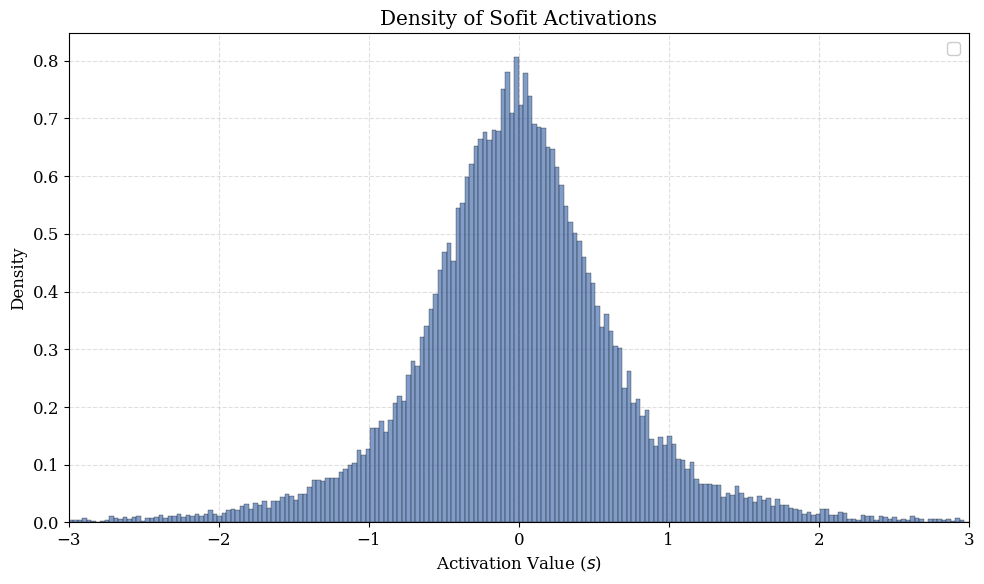

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from contextlib import contextmanager

# Define the style context again for consistency
@contextmanager
def paper_plot_style():
    plt.style.use('default')
    params = {
        'font.family': 'serif',
        'font.size': 12,
        'axes.grid': True,
        'grid.alpha': 0.4,
        'grid.linestyle': '--',
        'axes.axisbelow': True # Puts grid behind the bars
    }
    plt.rcParams.update(params)
    yield
    plt.style.use('default')

def analyze_sofit_log_robust(model, seed_text="KING RICHARD:", steps=500):
    print(f"--- RUNNING ROBUST LOG-SCALE ANALYSIS ---")
    model.eval()

    # 1. Collect Data
    h = torch.zeros(1, N_SOFITS, device=DEVICE)
    history = []

    ix = torch.tensor(encode(seed_text), device=DEVICE)
    with torch.no_grad():
        for t in range(ix.size(0)):
            x_emb = model.embed(ix[t].unsqueeze(0)).squeeze(1)
            h_context = model.topology(h)
            h, _ = model.gate(h_context, x_emb)

    curr_idx = ix[-1].unsqueeze(0)
    with torch.no_grad():
        for _ in range(steps):
            x_emb = model.embed(curr_idx).squeeze(1)
            h_context = model.topology(h)
            h, y_emit = model.gate(h_context, x_emb)
            history.append(h.cpu().numpy().flatten())
            curr_idx = torch.argmax(model.head(y_emit.unsqueeze(1)), dim=-1)

    flat_history = np.array(history).flatten()

    # ==========================================
    # ROBUST LOG-SCALE HISTOGRAM
    # ==========================================
    with paper_plot_style():
        fig, ax = plt.subplots(figsize=(10, 6))

        # Use standard matplotlib .hist() with log=True
        # This is much more stable than seaborn for this specific use case
        counts, bins, patches = ax.hist(
            flat_history,
            bins=200,                # High resolution
            range=(-3.0, 3.0),       # Zoomed range
            density=True,            # Normalize to PDF
            log=False,                # The Magic Switch
            color="#4c72b0",         # Professional Deep Blue
            alpha=0.7,
            edgecolor='black',       # Add faint edge to see bars clearly
            linewidth=0.3
        )

        # Highlight the Boolean Poles
        #ax.axvline(-1, color='#d62728', linestyle='--', linewidth=1.5, alpha=0.9, label='Boolean -1')
        #ax.axvline(1, color='#d62728', linestyle='--', linewidth=1.5, alpha=0.9, label='Boolean +1')

        ax.set_title("Density of Sofit Activations")
        ax.set_xlabel("Activation Value ($s$)")
        ax.set_ylabel("Density")
        ax.legend(loc='upper right', framealpha=1, frameon=True)

        # Force x-axis limits to ignore outliers
        ax.set_xlim(-3.0, 3.0)

        plt.tight_layout()
        plt.show()

analyze_sofit_log_robust(model)

<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3009219269.py:37: SyntaxWarning: invalid escape sequence '\m'
  axes[i, 0].text(0.05, 0.9, f"$\mu$={mu:.2f}\n$\sigma$={std:.2f}",
/tmp/ipython-input-3009219269.py:37: SyntaxWarning: invalid escape sequence '\s'
  axes[i, 0].text(0.05, 0.9, f"$\mu$={mu:.2f}\n$\sigma$={std:.2f}",
/tmp/ipython-input-3009219269.py:47: SyntaxWarning: invalid escape sequence '\m'
  axes[i, 1].text(0.05, 0.9, f"$\mu$={mu:.2f}\n$\sigma$={std:.2f}",
/tmp/ipython-input-3009219269.py:47: SyntaxWarning: invalid escape sequence '\s'
  axes[i, 1].text(0.05, 0.9, f"$\mu$={mu:.2f}\n$\sigma$={std:.2f

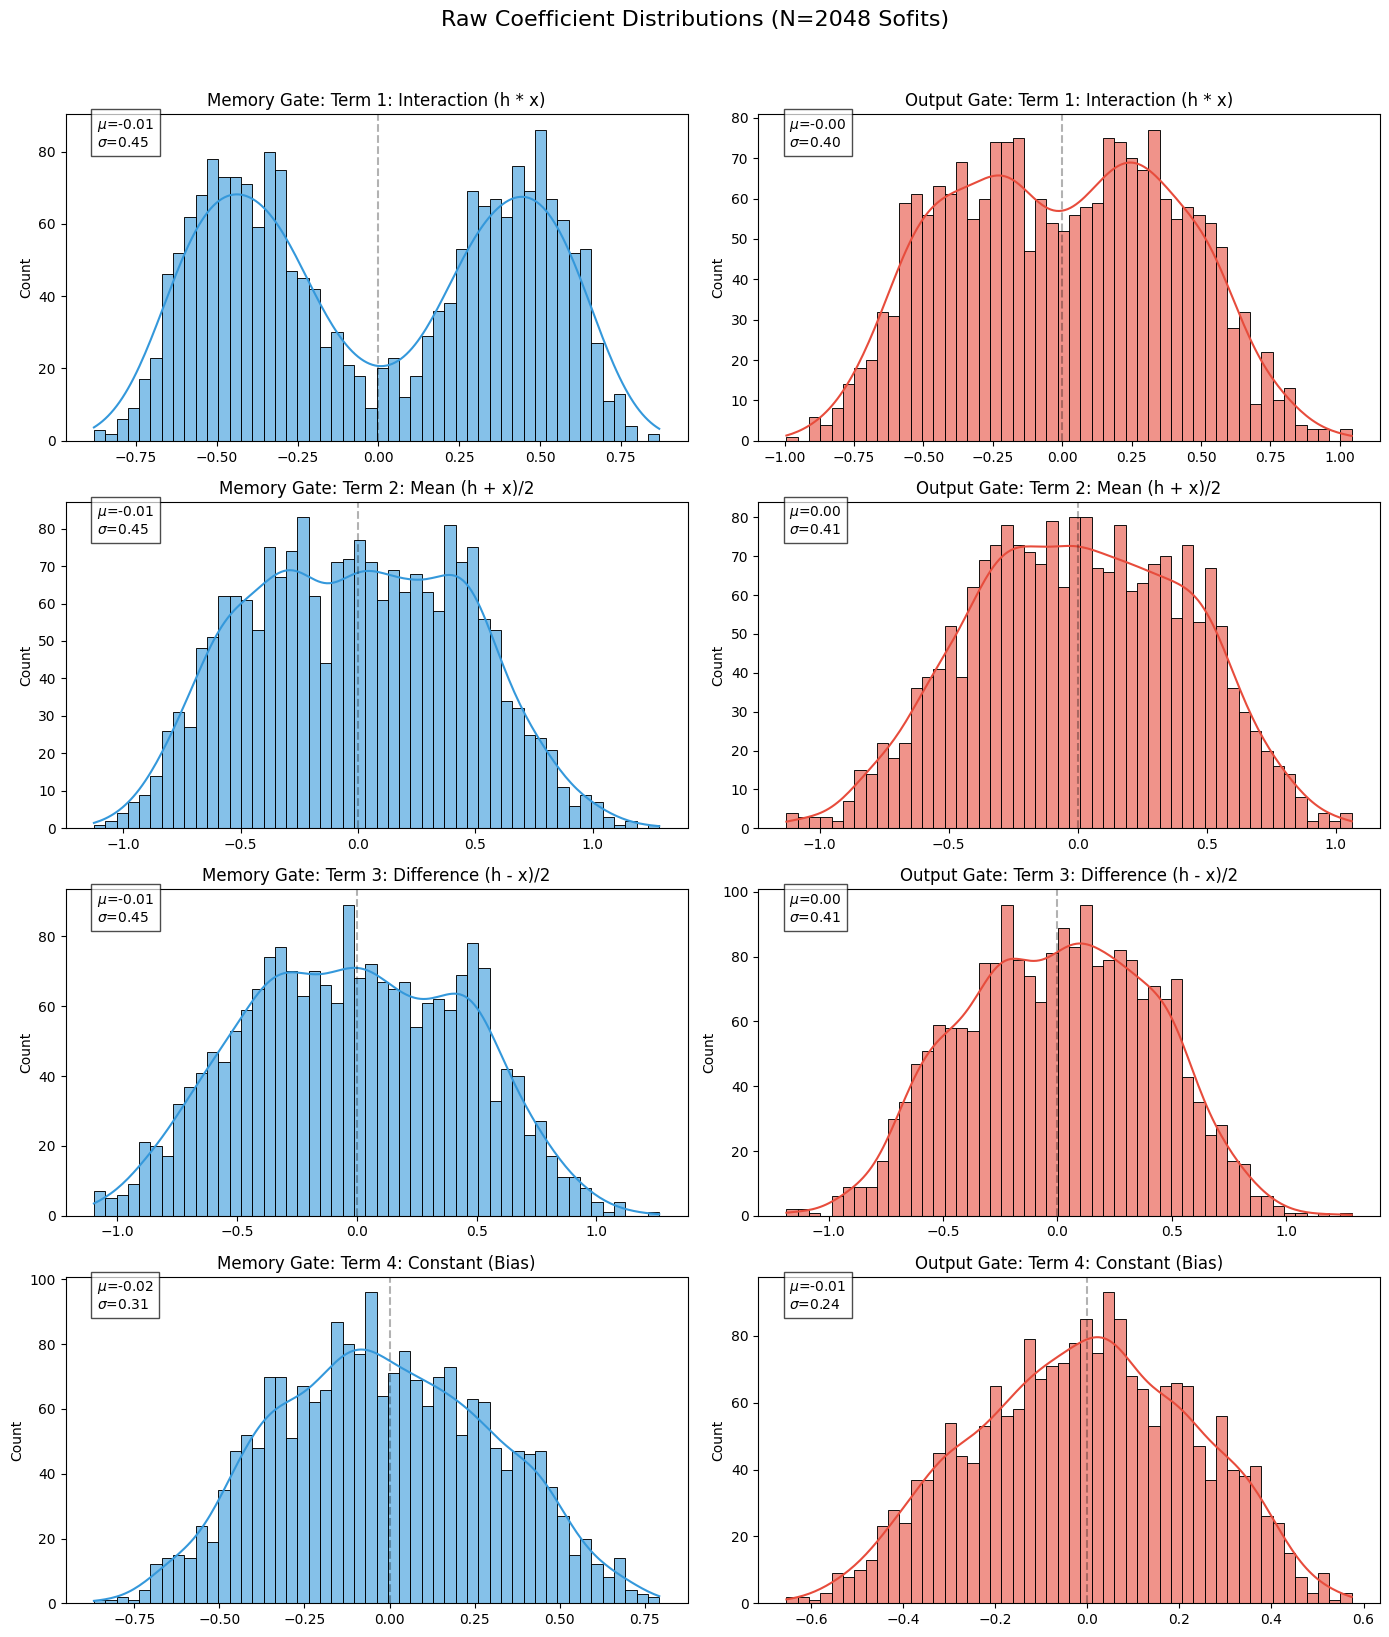

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

def plot_coefficient_histograms(model):
    # 1. Extract Weights (Shape: 4 x N_sofits)
    # Transpose so we have (N_sofits, 4)
    w_mem = model.gate.w_mem.detach().cpu().numpy().T
    w_out = model.gate.w_out.detach().cpu().numpy().T

    coeff_names = [
        "Term 1: Interaction (h * x)",
        "Term 2: Mean (h + x)/2",
        "Term 3: Difference (h - x)/2",
        "Term 4: Constant (Bias)"
    ]

    # 2. Setup Plot Grid: 4 Rows (Terms), 2 Columns (Gates)
    fig, axes = plt.subplots(4, 2, figsize=(14, 16))
    fig.suptitle(f"Raw Coefficient Distributions (N={w_mem.shape[0]} Sofits)", fontsize=16, y=1.02)

    # Define nice colors
    color_mem = '#3498db' # Blue
    color_out = '#e74c3c' # Red

    for i in range(4):
        # --- Memory Gate (Left Column) ---
        sns.histplot(w_mem[:, i], ax=axes[i, 0], color=color_mem, kde=True, bins=50, alpha=0.6)
        axes[i, 0].set_title(f"Memory Gate: {coeff_names[i]}")
        axes[i, 0].axvline(0, color='black', linestyle='--', alpha=0.3)
        axes[i, 0].set_ylabel("Count")

        # Calculate stats
        mu = np.mean(w_mem[:, i])
        std = np.std(w_mem[:, i])
        axes[i, 0].text(0.05, 0.9, f"$\mu$={mu:.2f}\n$\sigma$={std:.2f}",
                        transform=axes[i, 0].transAxes, bbox=dict(facecolor='white', alpha=0.7))

        # --- Output Gate (Right Column) ---
        sns.histplot(w_out[:, i], ax=axes[i, 1], color=color_out, kde=True, bins=50, alpha=0.6)
        axes[i, 1].set_title(f"Output Gate: {coeff_names[i]}")
        axes[i, 1].axvline(0, color='black', linestyle='--', alpha=0.3)

        mu = np.mean(w_out[:, i])
        std = np.std(w_out[:, i])
        axes[i, 1].text(0.05, 0.9, f"$\mu$={mu:.2f}\n$\sigma$={std:.2f}",
                        transform=axes[i, 1].transAxes, bbox=dict(facecolor='white', alpha=0.7))

    plt.tight_layout()
    plt.show()

# Run the analysis
plot_coefficient_histograms(model)

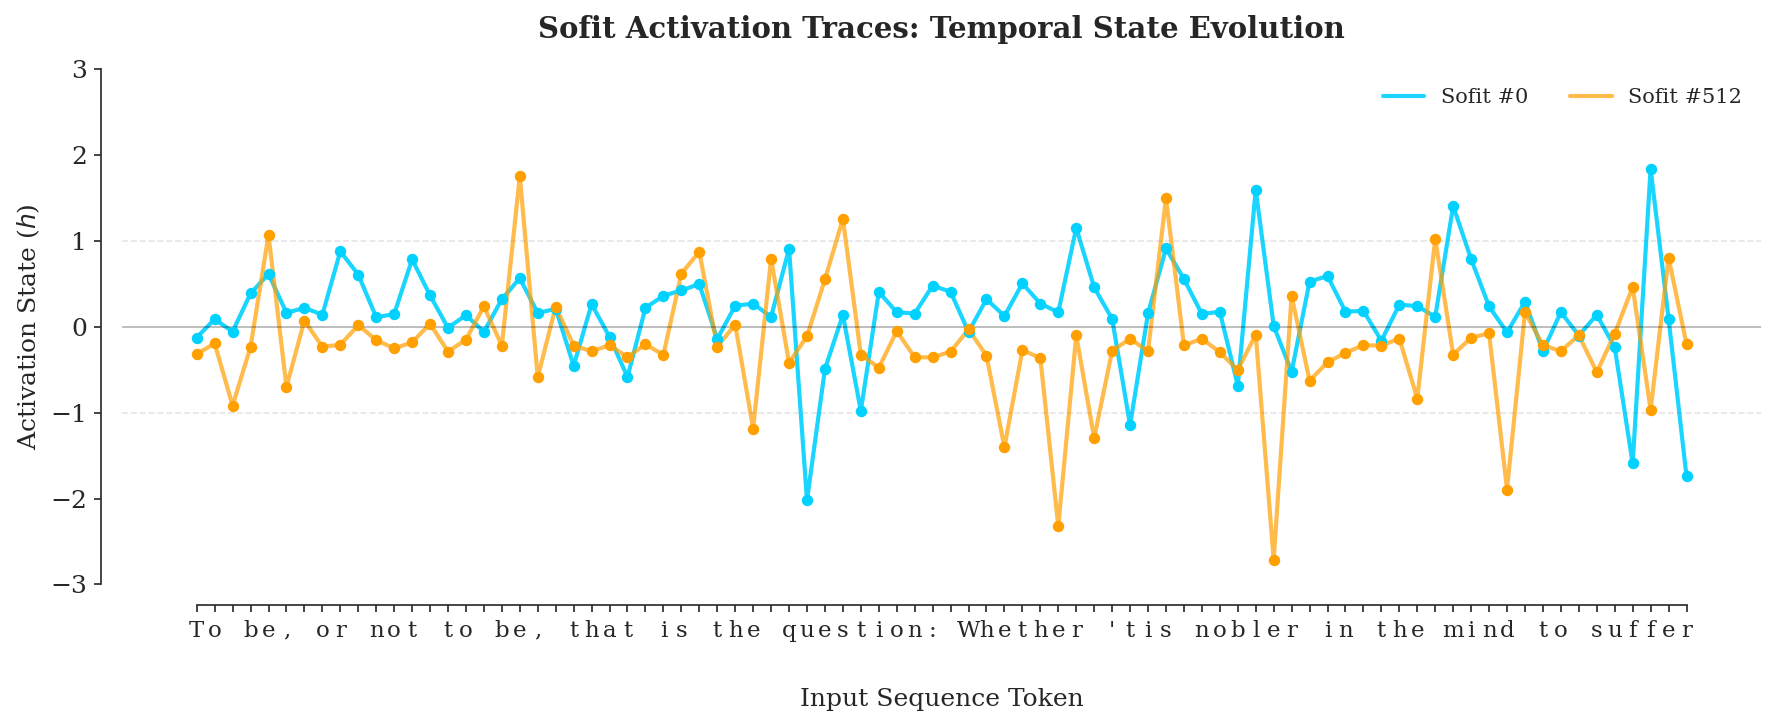

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Setup Academic Aesthetics
sns.set_style("ticks")
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "legend.fontsize": 10,
    "figure.dpi": 150
})

def plot_paper_quality_traces(sentence):
    ix = torch.tensor([encode(sentence)], device=DEVICE)
    h = torch.zeros(1, N_SOFITS, device=DEVICE)

    trace_0 = []
    trace_1 = []

    for t in range(ix.size(1)):
        x = model.embed(ix[:, t])
        h_c = model.topology(h)
        h, _ = model.gate(h_c, x)
        trace_0.append(h[0, 1].item())
        trace_1.append(h[0, 512].item())
    fig, ax = plt.subplots(figsize=(12, 5))

    # This reflects the Sofistron's behavior: state is constant until the next token
    ax.plot(trace_0, label='Sofit #0', color='#00d1ff', linewidth=2,
            drawstyle='default', alpha=0.9)

    ax.plot(trace_1, label='Sofit #512', color='#ff9f00', linewidth=2,
            drawstyle='default', alpha=0.7)

    # 3. Add discrete markers to highlight the 'Sync' points
    ax.scatter(range(len(trace_0)), trace_0, color='#00d1ff', s=20, zorder=3)
    ax.scatter(range(len(trace_1)), trace_1, color='#ff9f00', s=20, zorder=3)

    # 4. Refined Axis Labeling
    ax.set_xticks(range(len(sentence)))
    ax.set_xticklabels(list(sentence))

    # Add a slight "padding" to the y-axis to see the 1.0/-1.0 limits clearly
    ax.set_ylim(-3., 3.)
    ax.axhline(0, color='black', linewidth=0.8, alpha=0.3) # Baseline

    # 5. The "Ghost Wall" Indicators
    # Draw faint lines at the poles to show where the Sofit wants to settle
    ax.axhline(1.0, color='gray', linestyle='--', linewidth=0.8, alpha=0.2)
    ax.axhline(-1.0, color='gray', linestyle='--', linewidth=0.8, alpha=0.2)

    # 6. Styling
    ax.set_title("Sofit Activation Traces: Temporal State Evolution", fontweight='bold', pad=15)
    ax.set_ylabel("Activation State ($h$)")
    ax.set_xlabel("Input Sequence Token", labelpad=10)

    ax.legend(frameon=False, loc='upper right', ncol=2)

    # Remove top and right spines for a clean "Tufte" look
    sns.despine(offset=10, trim=True)

    plt.tight_layout()
    plt.show()

# Example Usage:
plot_paper_quality_traces(list("To be, or not to be, that is the question:\nWhether 'tis nobler in the mind to suffer"))

--- RUNNING LOGIC GATE CENSUS (BASIS: 1, Mean, Diff, Int) ---


/tmp/ipython-input-4227661352.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vals, y=names, ax=ax, palette=color_palette, edgecolor=".2")
/tmp/ipython-input-4227661352.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vals, y=names, ax=ax, palette=color_palette, edgecolor=".2")


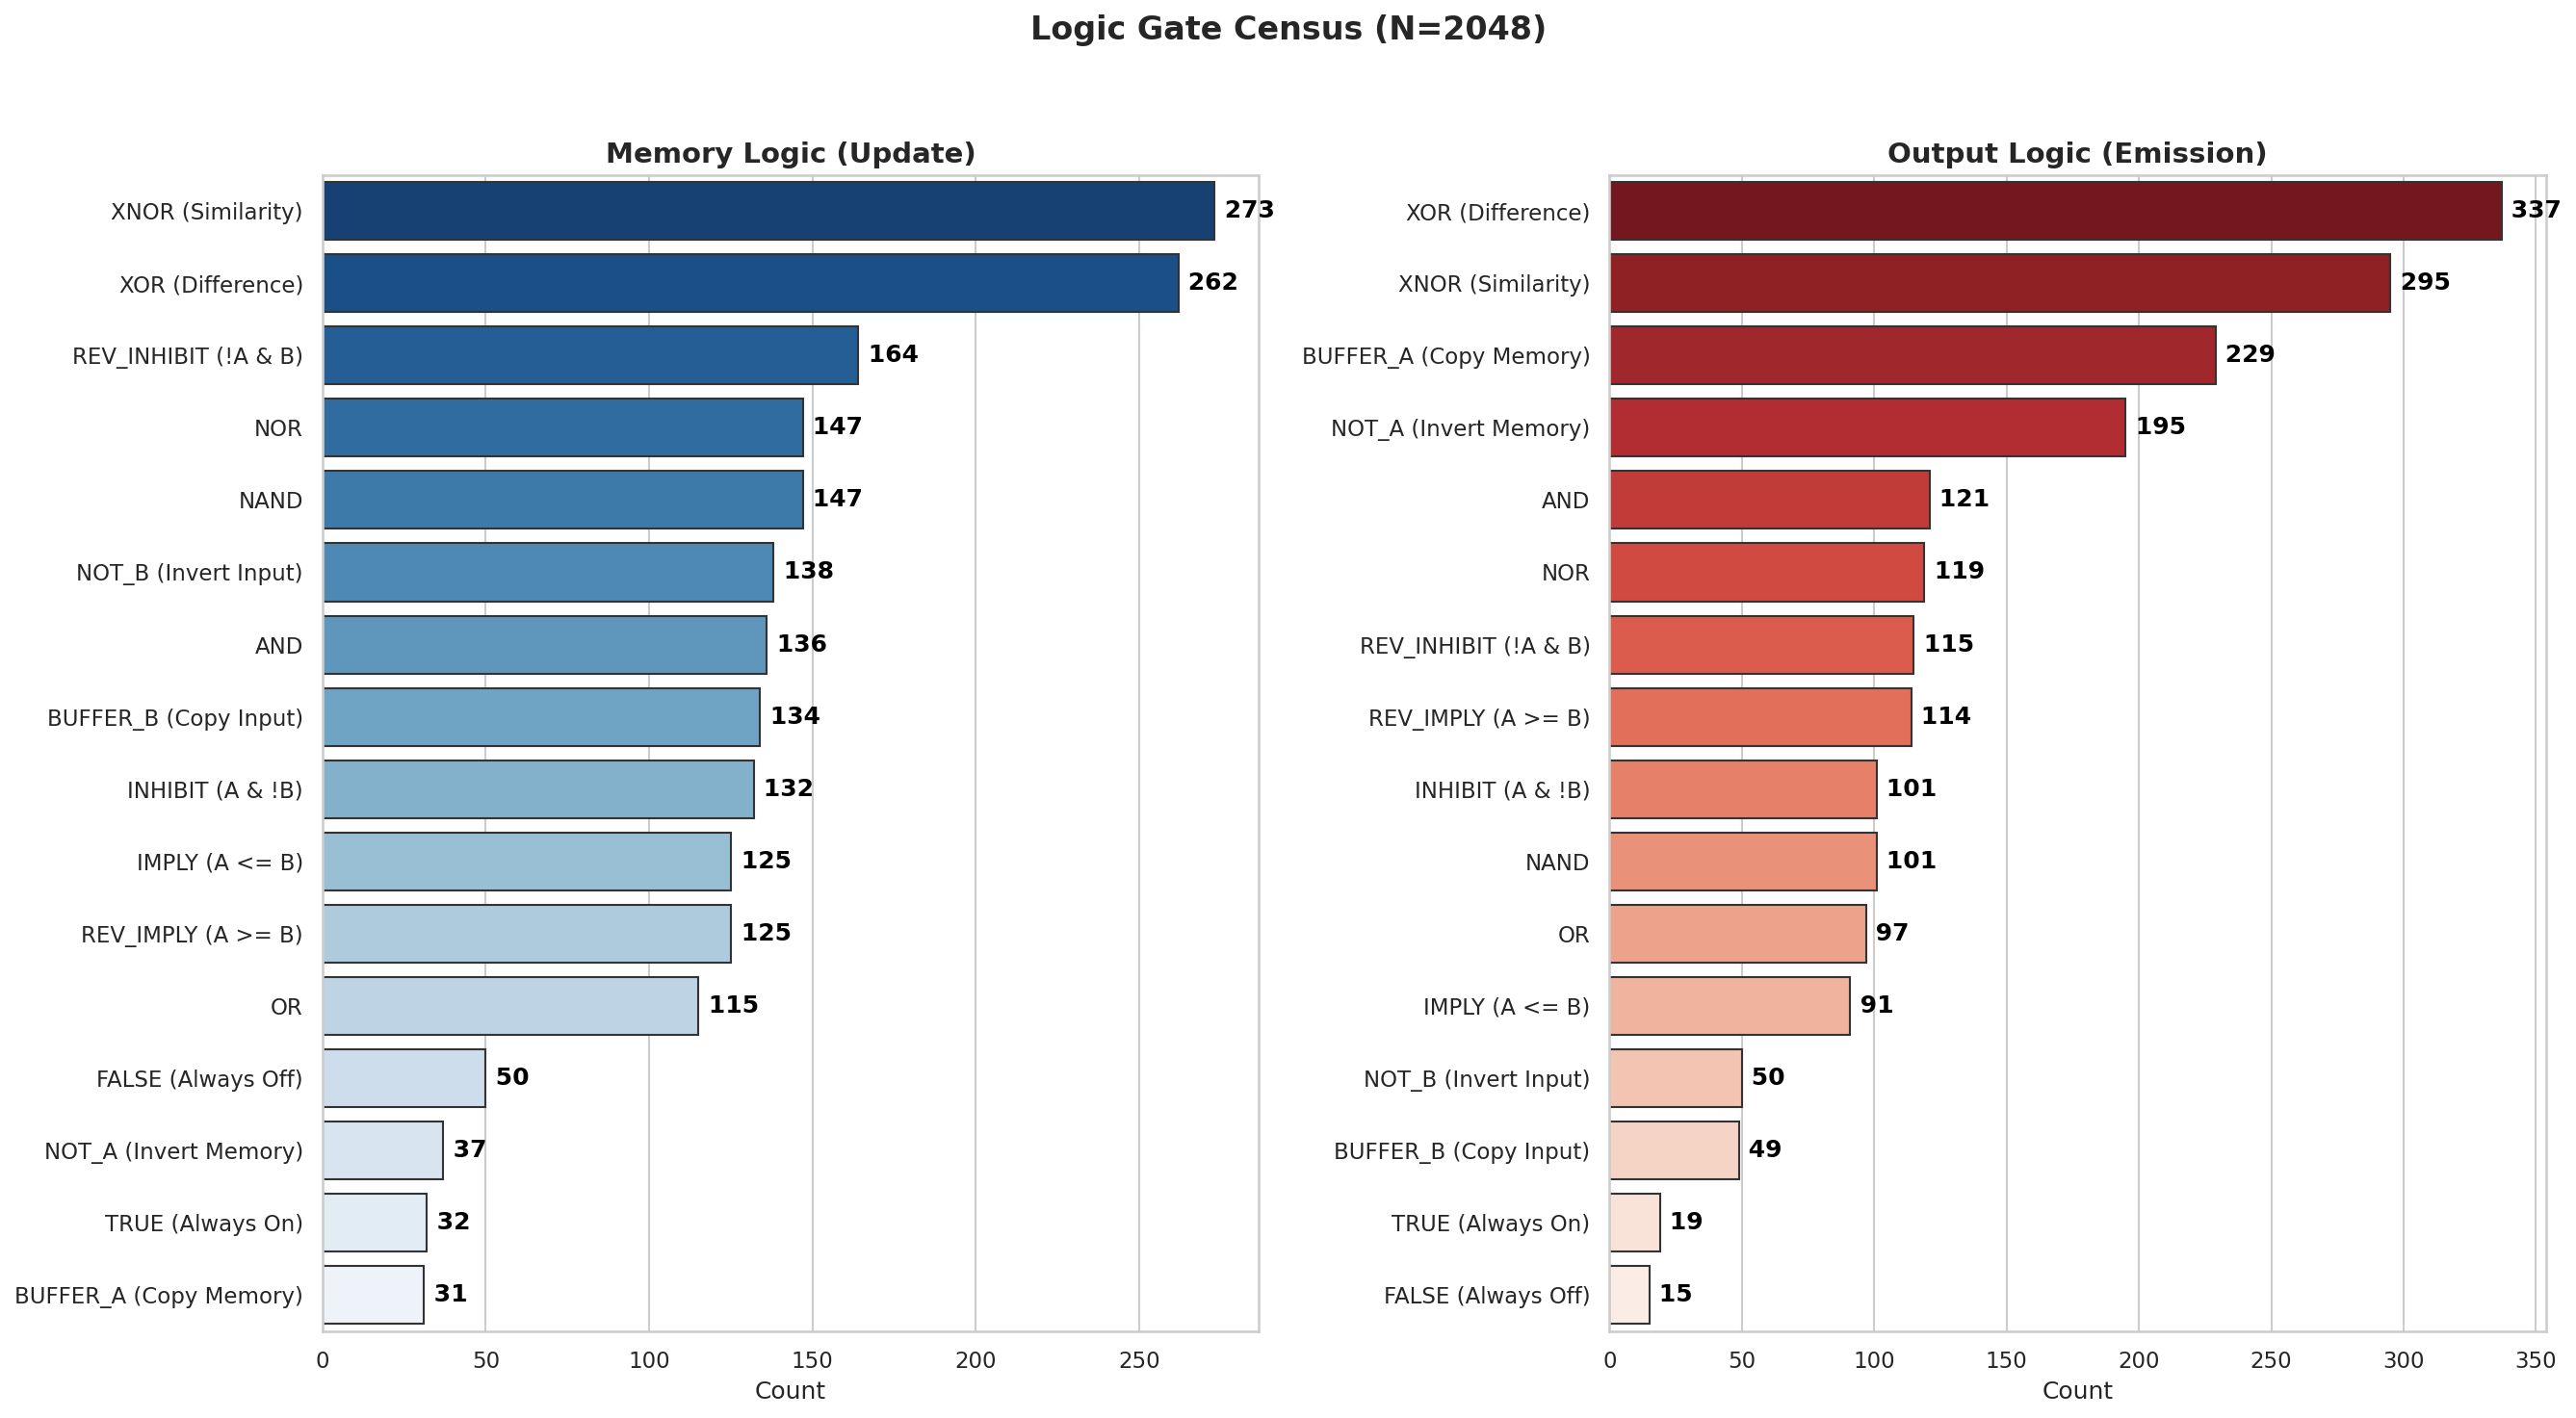

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def run_logic_gate_census(model):
    print("--- RUNNING LOGIC GATE CENSUS (BASIS: 1, Mean, Diff, Int) ---")

    # Auto-detect device
    DEVICE = model.gate.w_mem.device

    # 1. Logic Signatures (The 16 Boolean Functions)
    # Output pattern for inputs: [ (1,1), (1,-1), (-1,1), (-1,-1) ]
    # 1 = True, 0 = False
    gate_signatures = {
        (0,0,0,0): "FALSE (Always Off)",
        (0,0,0,1): "NOR",
        (0,0,1,0): "REV_INHIBIT (!A & B)",
        (0,0,1,1): "NOT_A (Invert Memory)",
        (0,1,0,0): "INHIBIT (A & !B)",
        (0,1,0,1): "NOT_B (Invert Input)",
        (0,1,1,0): "XOR (Difference)",
        (0,1,1,1): "NAND",
        (1,0,0,0): "AND",
        (1,0,0,1): "XNOR (Similarity)",
        (1,0,1,0): "BUFFER_B (Copy Input)",
        (1,0,1,1): "IMPLY (A <= B)",
        (1,1,0,0): "BUFFER_A (Copy Memory)",
        (1,1,0,1): "REV_IMPLY (A >= B)",
        (1,1,1,0): "OR",
        (1,1,1,1): "TRUE (Always On)"
    }

    # 2. Probe Inputs (h, x)
    probes = torch.tensor([
        [ 1.0,  1.0], # TT
        [ 1.0, -1.0], # TF
        [-1.0,  1.0], # FT
        [-1.0, -1.0]  # FF
    ], device=DEVICE)

    # 3. Classifier
    def classify_gates(weights):
        # weights shape: (4, N_SOFITS)
        # ASSUMPTION: The stack order in 'm_parts' was [Int, Mean, Diff, Const]
        # If your stack order is different, swap the indices below.

        N_SOFITS = weights.shape[1]
        counts = {name: 0 for name in gate_signatures.values()}
        w_all = weights.detach().cpu().numpy() # Move to CPU for fast loop

        for i in range(N_SOFITS):
            w = w_all[:, i]

            # Map weights to your specific Basis Terms
            # w[0] -> Interaction (xy)
            # w[1] -> Mean ((x+y)/2)
            # w[2] -> Diff ((x-y)/2)
            # w[3] -> Constant (1)  <-- FIXED: Multiplier is 1.0, not 0.5

            w_int   = w[0]
            w_mean  = w[1]
            w_diff  = w[2]
            w_const = w[3]

            outputs = []
            for h, x in probes:
                # Calculate z using YOUR exact basis
                val_int   = h * x
                val_mean  = (h + x) * 0.5
                val_diff  = (h - x) * 0.5
                val_const = 1.0            # <--- THE FIX

                z = (w_int * val_int) + (w_mean * val_mean) + (w_diff * val_diff) + (w_const * val_const)

                # Threshold at 0
                outputs.append(1 if z > 0 else 0)

            sig = tuple(outputs)
            gate_name = gate_signatures.get(sig, "UNKNOWN")
            counts[gate_name] += 1

        return counts

    # 4. Run Analysis
    mem_counts = classify_gates(model.gate.w_mem)
    out_counts = classify_gates(model.gate.w_out)

    # 5. Plotting
    sns.set_theme(style="whitegrid")
    fig, axs = plt.subplots(1, 2, figsize=(18, 10))
    fig.suptitle(f"Logic Gate Census (N={model.gate.w_mem.shape[1]})", fontsize=16, weight='bold')

    def plot_counts(counts, ax, title, color_palette):
        sorted_gates = sorted(counts.items(), key=lambda item: item[1], reverse=True)
        names = [k for k,v in sorted_gates]
        vals = [v for k,v in sorted_gates]

        # Filter out 0 counts to keep chart clean
        names = [n for i, n in enumerate(names) if vals[i] > 0]
        vals = [v for v in vals if v > 0]

        sns.barplot(x=vals, y=names, ax=ax, palette=color_palette, edgecolor=".2")
        ax.set_title(title, fontsize=14, weight='bold')
        ax.set_xlabel("Count")

        for i, v in enumerate(vals):
            ax.text(v + 0.5, i, f" {v}", color='black', va='center', fontweight='bold')

    plot_counts(mem_counts, axs[0], "Memory Logic (Update)", "Blues_r")
    plot_counts(out_counts, axs[1], "Output Logic (Emission)", "Reds_r")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Run
run_logic_gate_census(model)

--- RUNNING SELF-REPAIR TEST (Noise Scale=3.0) ---
!!! INJECTING NOISE AT STEP 20 (' ') !!!


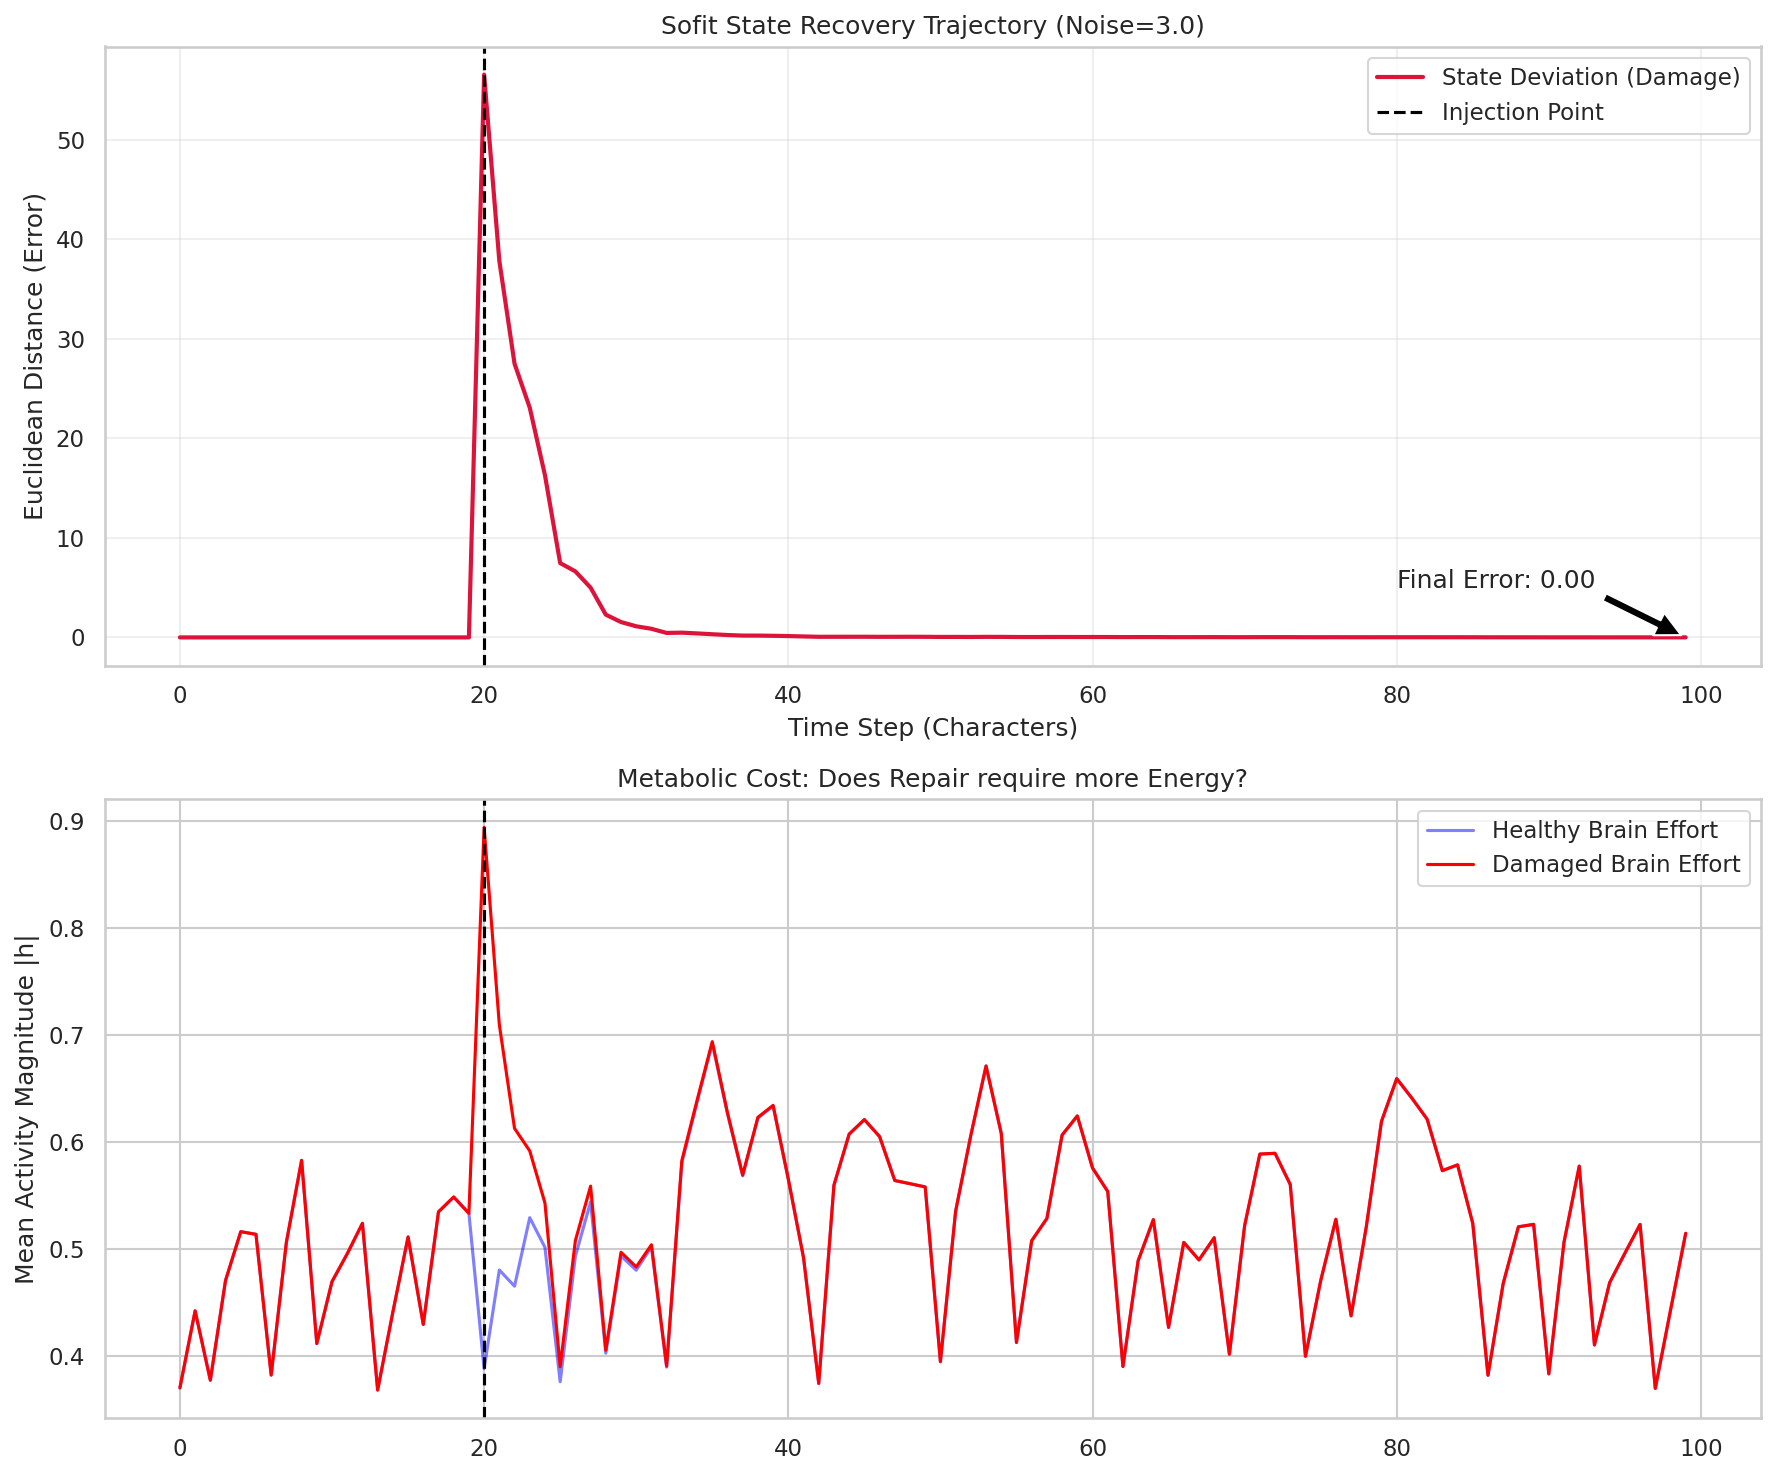

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# BRAIN HACK: PERTURBATION & RECOVERY
# ==========================================
def test_error_correction(model, sequence_length=100, noise_scale=3.0):
    print(f"--- RUNNING SELF-REPAIR TEST (Noise Scale={noise_scale}) ---")
    model.eval()

    # 1. Setup Data
    text = "To be, or not to be, that is the question: Whether 'tis nobler in the mind to suffer"
    # Ensure text is long enough
    while len(text) < sequence_length: text += text
    text = text[:sequence_length]

    ix = torch.tensor([encode(text)], device=DEVICE)

    # 2. Run HEALTHY Trajectory (Baseline)
    h_clean = torch.zeros(1, N_SOFITS, device=DEVICE)
    traj_clean = []

    with torch.no_grad():
        for t in range(sequence_length):
            x = model.embed(ix[:, t])
            h_context = model.topology(h_clean)
            h_clean, _ = model.gate(h_context, x)
            traj_clean.append(h_clean.cpu().numpy().flatten())

    traj_clean = np.array(traj_clean)

    # 3. Run DAMAGED Trajectory (The "Hack")
    h_dirty = torch.zeros(1, N_SOFITS, device=DEVICE)
    traj_dirty = []
    damage_step = 20 # Inject noise at character 20

    with torch.no_grad():
        for t in range(sequence_length):
            x = model.embed(ix[:, t])

            # --- THE HACK ---
            if t == damage_step:
                print(f"!!! INJECTING NOISE AT STEP {t} ('{text[t]}') !!!")
                # We add random noise to the state
                noise = torch.randn_like(h_dirty) * noise_scale
                h_dirty = h_dirty + noise

            h_context = model.topology(h_dirty)
            h_dirty, _ = model.gate(h_context, x)
            traj_dirty.append(h_dirty.cpu().numpy().flatten())

    traj_dirty = np.array(traj_dirty)

    # 4. Measure "Healing" (Euclidean Distance between Clean and Dirty)
    # distance[t] = ||h_clean[t] - h_dirty[t]||
    distances = np.linalg.norm(traj_clean - traj_dirty, axis=1)

    # ==========================================
    # VISUALIZATION
    # ==========================================
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))

    # PLOT A: The Healing Curve
    axs[0].plot(distances, color='crimson', linewidth=2, label='State Deviation (Damage)')
    axs[0].axvline(x=damage_step, color='black', linestyle='--', label='Injection Point')
    axs[0].set_title(f"Sofit State Recovery Trajectory (Noise={noise_scale})")
    axs[0].set_ylabel("Euclidean Distance (Error)")
    axs[0].set_xlabel("Time Step (Characters)")
    axs[0].legend()
    axs[0].grid(True, alpha=0.3)

    # Add annotation
    final_err = distances[-1]
    axs[0].annotate(f"Final Error: {final_err:.2f}", xy=(sequence_length-1, final_err),
                    xytext=(sequence_length-20, final_err+5),
                    arrowprops=dict(facecolor='black', shrink=0.05))

    # PLOT B: The Predictive Coding Check (Activity Magnitude)
    # We want to see if the "Dirty" brain has to work harder (higher spikes) to fix itself
    # Calculate magnitude of activity |h|
    mag_clean = np.mean(np.abs(traj_clean), axis=1)
    mag_dirty = np.mean(np.abs(traj_dirty), axis=1)

    axs[1].plot(mag_clean, color='blue', alpha=0.5, label='Healthy Brain Effort')
    axs[1].plot(mag_dirty, color='red', label='Damaged Brain Effort')
    axs[1].axvline(x=damage_step, color='black', linestyle='--')
    axs[1].set_title("Metabolic Cost: Does Repair require more Energy?")
    axs[1].set_ylabel("Mean Activity Magnitude |h|")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

test_error_correction(model)

--- RUNNING SEMANTIC SPECTROSCOPY ---


/tmp/ipython-input-2466216548.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,0].set_xticklabels(all_words, rotation=90)


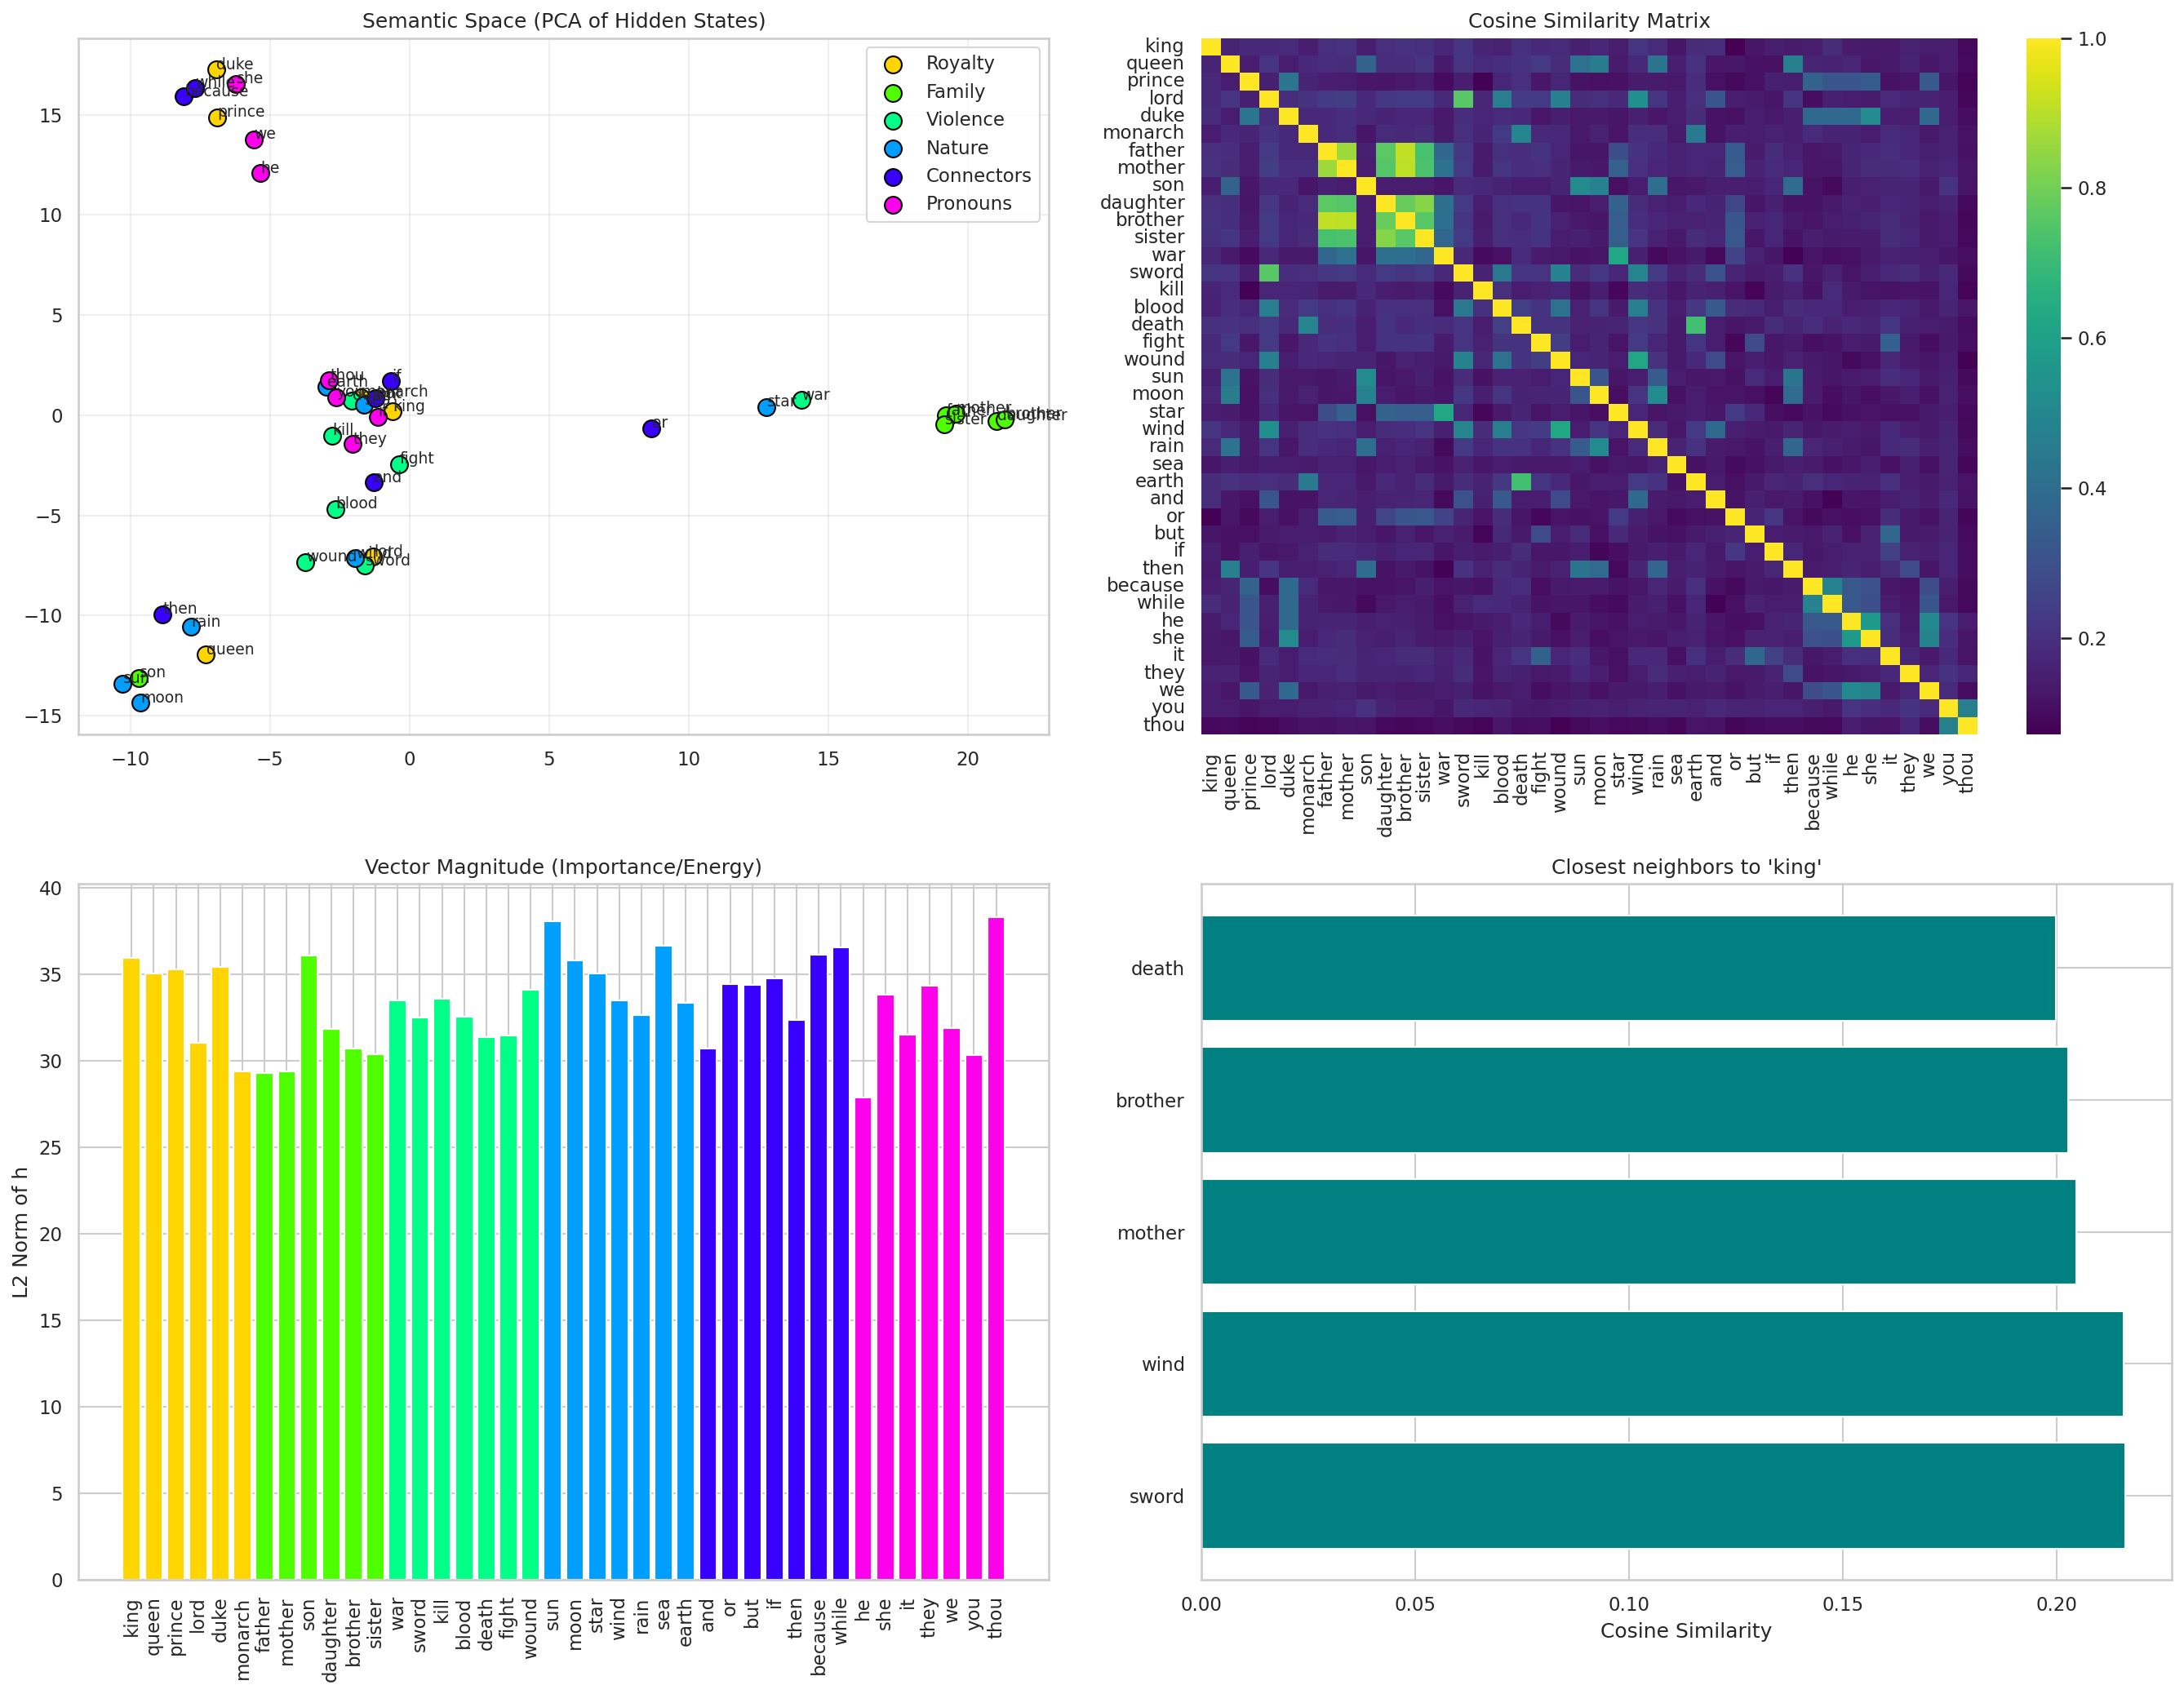

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

def analyze_word_embeddings(model):
    print("--- RUNNING SEMANTIC SPECTROSCOPY ---")
    model.eval()

    # 1. Define Semantic Clusters
    # We want to see if the model groups these concepts automatically
    word_groups = {
        "Royalty": ["king", "queen", "prince", "lord", "duke", "monarch"],
        "Family": ["father", "mother", "son", "daughter", "brother", "sister"],
        "Violence": ["war", "sword", "kill", "blood", "death", "fight", "wound"],
        "Nature": ["sun", "moon", "star", "wind", "rain", "sea", "earth"],
        "Connectors": ["and", "or", "but", "if", "then", "because", "while"],
        "Pronouns": ["he", "she", "it", "they", "we", "you", "thou"]
    }

    # Flatten list for processing
    all_words = []
    labels = []
    colors = []
    group_names = list(word_groups.keys())
    palette = sns.color_palette("hsv", len(group_names))

    for i, (group, words) in enumerate(word_groups.items()):
        for w in words:
            all_words.append(w)
            labels.append(group)
            colors.append(palette[i])

    # 2. Extract Embeddings (The "Final h")
    embeddings = []
    magnitudes = []

    with torch.no_grad():
        for w in all_words:
            # We add a leading space to simulate natural separation
            # e.g., " king" instead of "king"
            text_seq = " " + w
            ix = torch.tensor([encode(text_seq)], device=DEVICE)

            # Reset state (Context-Free Embedding)
            h = torch.zeros(1, N_SOFITS, device=DEVICE)

            for t in range(ix.size(1)):
                x = model.embed(ix[:, t])
                h_context = model.topology(h)
                h, _ = model.gate(h_context, x)

            # The final h is our "Word Vector"
            vec = h.cpu().numpy().flatten()
            embeddings.append(vec)
            magnitudes.append(np.linalg.norm(vec))

    embeddings = np.array(embeddings)

    # 3. ANALYSIS A: Similarity Matrix
    # Who is closest to "King"?
    sim_matrix = cosine_similarity(embeddings)

    # 4. ANALYSIS B: PCA Projection (2D Map)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)

    # ==========================================
    # VISUALIZATION
    # ==========================================
    fig, axs = plt.subplots(2, 2, figsize=(18, 14))

    # PLOT 1: The Semantic Map (PCA)
    # Do "King" and "Queen" land near each other?
    for i, group in enumerate(group_names):
        # Filter points by group
        indices = [j for j, x in enumerate(labels) if x == group]
        x_pts = pca_result[indices, 0]
        y_pts = pca_result[indices, 1]
        axs[0,0].scatter(x_pts, y_pts, c=[palette[i]], label=group, s=100, edgecolors='black')

        # Annotate specific words
        for j in indices:
            axs[0,0].annotate(all_words[j], (pca_result[j,0]+0.02, pca_result[j,1]+0.02), fontsize=9)

    axs[0,0].set_title("Semantic Space (PCA of Hidden States)")
    axs[0,0].legend()
    axs[0,0].grid(True, alpha=0.3)

    # PLOT 2: Similarity Heatmap
    # Block diagonal structure = Good clustering
    sns.heatmap(sim_matrix, ax=axs[0,1], cmap='viridis', xticklabels=all_words, yticklabels=all_words)
    axs[0,1].set_title("Cosine Similarity Matrix")

    # PLOT 3: Embedding Magnitude (The "Volume")
    # Does "King" have a bigger vector than "the"?
    axs[1,0].bar(all_words, magnitudes, color=colors)
    axs[1,0].set_xticklabels(all_words, rotation=90)
    axs[1,0].set_title("Vector Magnitude (Importance/Energy)")
    axs[1,0].set_ylabel("L2 Norm of h")

    # PLOT 4: Nearest Neighbor Check (Sanity Test)
    # Let's find the closest neighbor for 'king' and 'war'
    def plot_neighbors(target_word, ax_idx):
        if target_word not in all_words: return
        idx = all_words.index(target_word)
        sims = sim_matrix[idx]
        # Sort indices by similarity
        sorted_indices = np.argsort(sims)[::-1]

        top_5_words = [all_words[i] for i in sorted_indices[1:6]] # Skip self
        top_5_scores = [sims[i] for i in sorted_indices[1:6]]

        axs[1,1].barh(top_5_words, top_5_scores, color='teal')
        axs[1,1].set_title(f"Closest neighbors to '{target_word}'")
        axs[1,1].set_xlabel("Cosine Similarity")

    plot_neighbors("king", 1) # Plot neighbors for King

    plt.tight_layout()
    plt.show()

analyze_word_embeddings(model)

In [12]:
import torch
import torch.nn.functional as F

def generate_shakespeare_page(model, seed_text="\n", max_length=2000, temperature=1.0):
    print(f"--- GENERATING {max_length} CHARACTERS (Temp={temperature}) ---")
    model.eval()

    # 1. Initialize the Brain (Empty State)
    h = torch.zeros(1, N_SOFITS, device=DEVICE)

    # 2. Warm-Up Phase (Reading the Seed)
    # We feed the seed text to build up the internal state 'h'
    # but we don't generate anything yet.

    seed_tokens = encode(seed_text)
    print(seed_text, end='', flush=True)

    with torch.no_grad():
        # A. Process the seed to set the context
        for t in range(len(seed_tokens)):
            # Get token tensor
            idx = torch.tensor([[seed_tokens[t]]], device=DEVICE) # (1,1)

            # Embed
            x_emb = model.embed(idx).squeeze(1) # (1, n_sofits)

            # Update State (Thinking)
            h_context = model.topology(h)
            h, _ = model.gate(h_context, x_emb)

        # B. Generation Phase (The Hallucination)
        # We start with the last token of the seed
        curr_idx = torch.tensor([[seed_tokens[-1]]], device=DEVICE)

        for _ in range(max_length):
            # 1. Embed current token
            x_emb = model.embed(curr_idx).squeeze(1)

            # 2. Update State
            h_context = model.topology(h)
            h, y_emit = model.gate(h_context, x_emb)

            # 3. Predict Next Token
            # We treat y_emit as a sequence of length 1 for the head
            logits = model.head(model.dropout(y_emit.unsqueeze(1))) # (1, 1, vocab)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)

            # 4. Sample
            idx_next = torch.multinomial(probs, num_samples=1)

            # 5. Print & Advance
            char = decode([idx_next.item()])
            print(char, end='', flush=True)

            curr_idx = idx_next

    print("\n\n--- END OF SCENE ---")

# USAGE:
# High Temp (1.1) = More creative/risky
# Low Temp (0.8) = More conservative/grammatical
generate_shakespeare_page(model, seed_text="To be or not to be ", max_length=2000, temperature=.3)

--- GENERATING 2000 CHARACTERS (Temp=0.3) ---
To be or not to be the country,
And there is a prince thou art thou wilt thou art thou hast a friends,
That thou not do thee to the prince that we have been the way,
The prince that thou shalt die the strength and advised with a short and the courtesy.

First Senator:
He was the great soul to hear the world is some sentence.

CLARENCE:
O fair cousin of the market-place to the love,
That the shame to the man and the air to the state,
That thou art thou art thou art thou art thou hast thou art thou speak.

DUKE OF YORK:
Why, that the man that we shall see thee she was a father speak.

BRUTUS:
The country's son and prove the souls,
And not the blood that we are there is not the prince,
And had the prince that he was not the country and the speech of the gods of his hands
Of the matter with the country than the world is the sight of the prince,
And what is the common more of what they shall see the court?

MENENIUS:
The sea the souls and heart 

--- 🔬 SCANNING NEURAL DYNAMICS (T=4096) ---


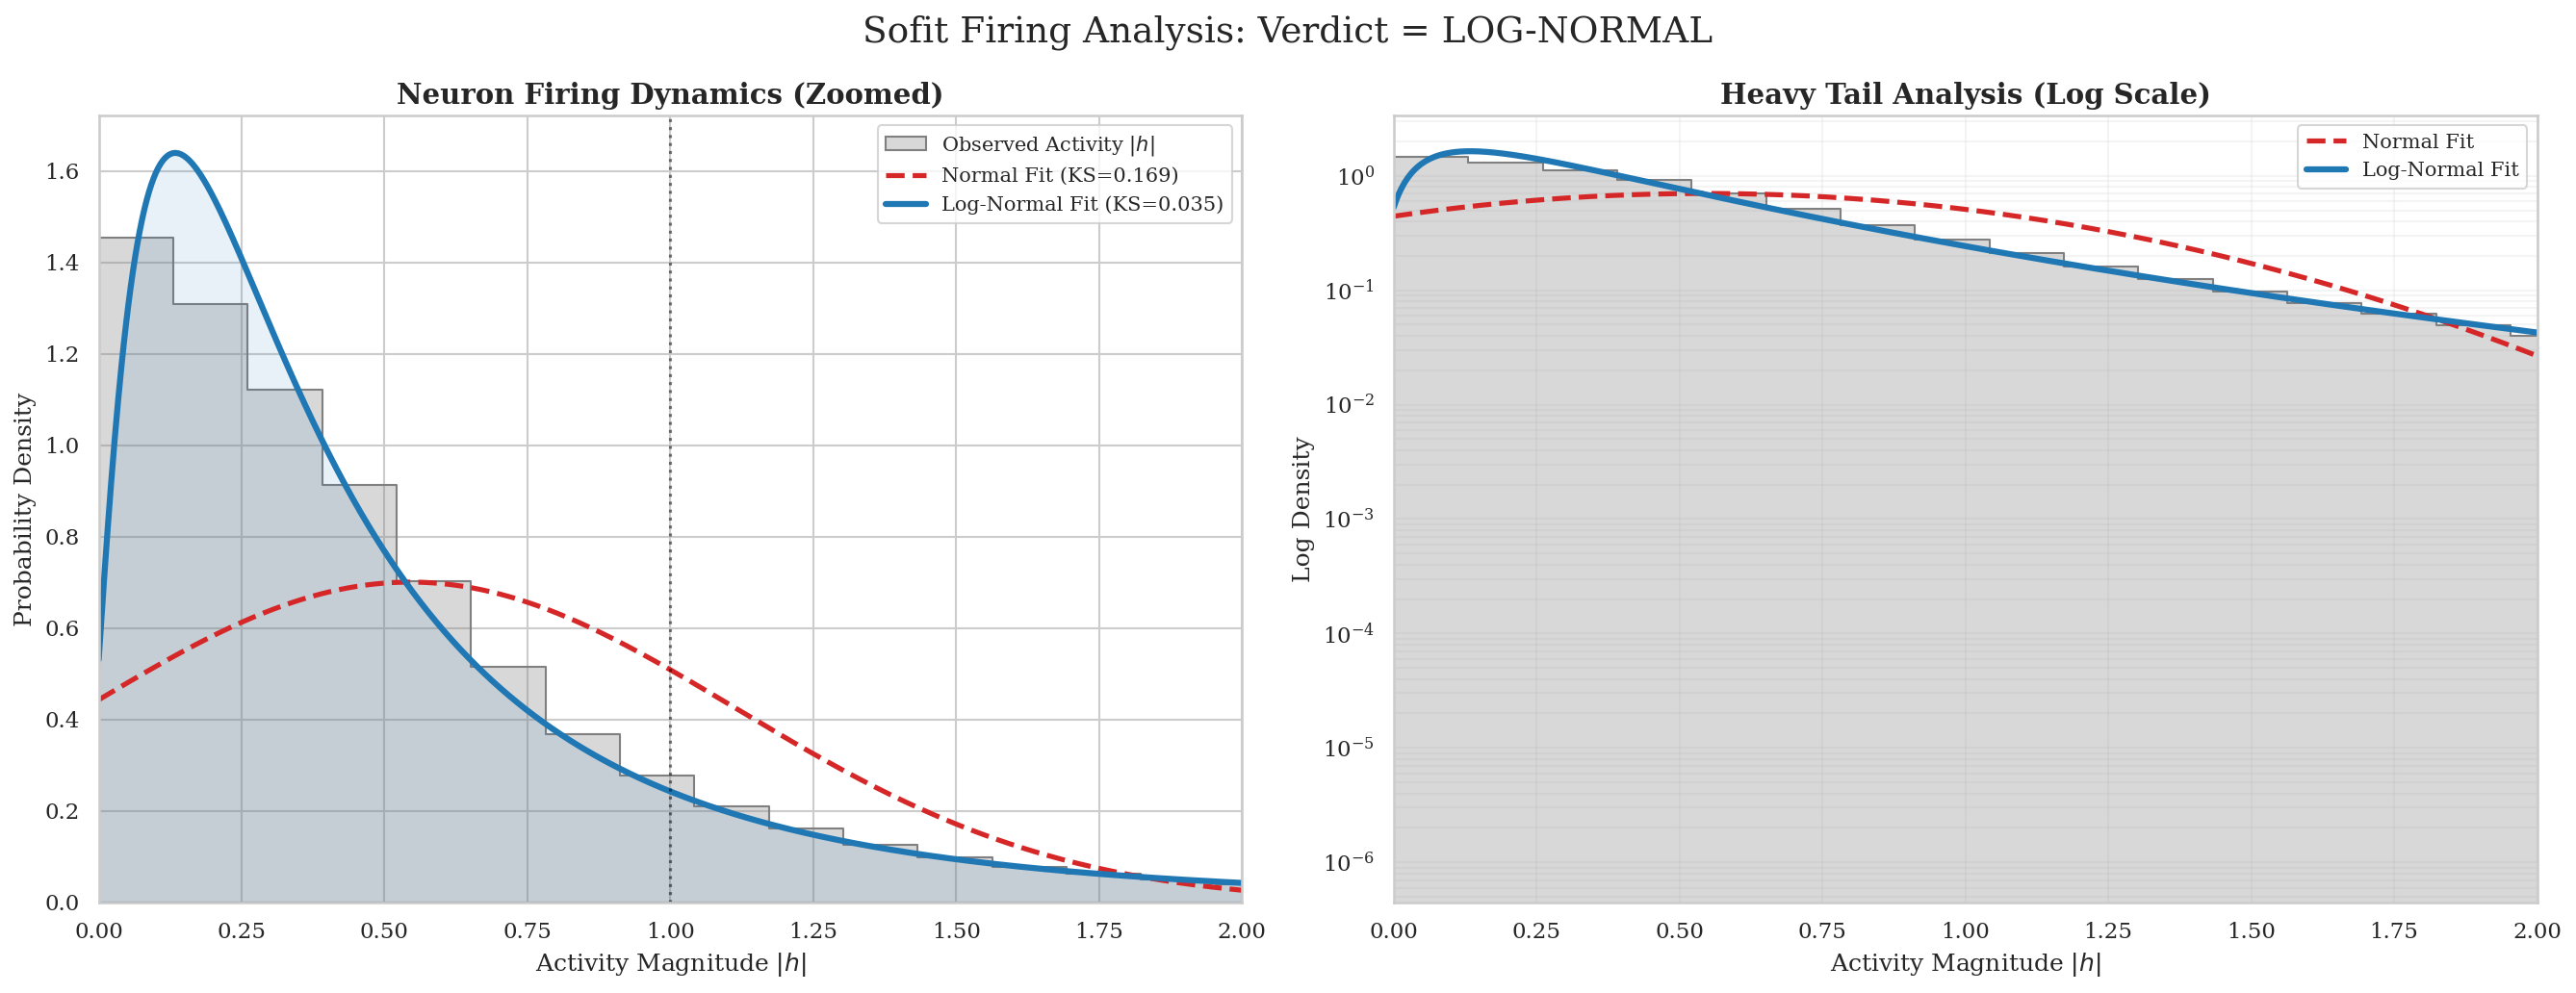

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'

def visualize_spiking_zoom(model, data_str, sequence_length=4096, device='cuda'):
    print(f"--- 🔬 SCANNING NEURAL DYNAMICS (T={sequence_length}) ---")
    model.eval()

    # --- 1. HARVEST ACTIVITY ---
    start_idx = 6000
    ix = torch.tensor([encode(data_str[start_idx:start_idx+sequence_length])], device=device)
    h = torch.zeros(1, model.n_sofits, device=device)
    h_values = []

    with torch.no_grad():
        for t in range(sequence_length):
            x = model.embed(ix[:, t])
            h_context = model.topology(h)
            h, _ = model.gate(h_context, x)
            h_values.append(torch.abs(h).cpu().numpy().flatten())

    data = np.array(h_values).flatten()
    data = data[data > 1e-5]

    # --- 2. STATISTICAL FITTING ---
    mu_n, std_n = stats.norm.fit(data)
    shape_l, loc_l, scale_l = stats.lognorm.fit(data)

    # Subsample for KS Test
    subsample = np.random.choice(data, min(5000, len(data)), replace=False)
    ks_norm = stats.kstest(subsample, 'norm', args=(mu_n, std_n)).statistic
    ks_log = stats.kstest(subsample, 'lognorm', args=(shape_l, loc_l, scale_l)).statistic
    verdict = "Log-Normal" if ks_log < ks_norm else "Normal"

    # --- 3. VISUALIZATION (FOCUSED VIEW) ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # Define the "Interesting Zone"
    ZOOM_LIMIT = 2.0
    x = np.linspace(0, ZOOM_LIMIT, 1000)

    pdf_norm = stats.norm.pdf(x, mu_n, std_n)
    pdf_lognorm = stats.lognorm.pdf(x, shape_l, loc_l, scale_l)

    # === PLOT 1: Linear Scale (Zoomed) ===
    sns.histplot(data, bins=100, stat="density", color="gray", alpha=0.3,
                 element="step", label='Observed Activity $|h|$', ax=ax1)

    ax1.plot(x, pdf_norm, color='#d62728', linestyle='--', linewidth=2.5,
             label=f'Normal Fit (KS={ks_norm:.3f})')
    ax1.plot(x, pdf_lognorm, color='#1f77b4', linewidth=3,
             label=f'Log-Normal Fit (KS={ks_log:.3f})')

    if verdict == "Log-Normal":
        ax1.fill_between(x, pdf_lognorm, alpha=0.1, color='#1f77b4')

    ax1.set_xlim(0, ZOOM_LIMIT)  # <--- FORCE THE ZOOM
    ax1.set_title("Neuron Firing Dynamics (Zoomed)", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Activity Magnitude $|h|$", fontsize=12)
    ax1.set_ylabel("Probability Density", fontsize=12)
    ax1.legend(fontsize=10, loc='upper right')

    # Add the "Ghost Wall" line
    ax1.axvline(1.0, color='black', linestyle=':', alpha=0.5, label='Digitization Limit')

    # === PLOT 2: Log Scale (Zoomed Tail) ===
    sns.histplot(data, bins=100, stat="density", color="gray", alpha=0.3,
                 element="step", ax=ax2)

    ax2.plot(x, pdf_norm, color='#d62728', linestyle='--', linewidth=2.5, label='Normal Fit')
    ax2.plot(x, pdf_lognorm, color='#1f77b4', linewidth=3, label='Log-Normal Fit')

    ax2.set_xlim(0, ZOOM_LIMIT)  # <--- FORCE THE ZOOM
    ax2.set_yscale('log')
    ax2.set_title("Heavy Tail Analysis (Log Scale)", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Activity Magnitude $|h|$", fontsize=12)
    ax2.set_ylabel("Log Density", fontsize=12)
    ax2.grid(True, which="both", ls="-", alpha=0.2)
    ax2.legend(fontsize=10, loc='upper right')

    fig.suptitle(f"Sofit Firing Analysis: Verdict = {verdict.upper()}", fontsize=18, y=0.98)
    plt.tight_layout()
    plt.show()

# --- Usage ---
visualize_spiking_zoom(model, data_str)

--- 🕵️ INTERPRETABILITY SCAN: 'To be, or not to be,...' ---
Top Active sofits Found: [1853 1113  197 1460 1393]


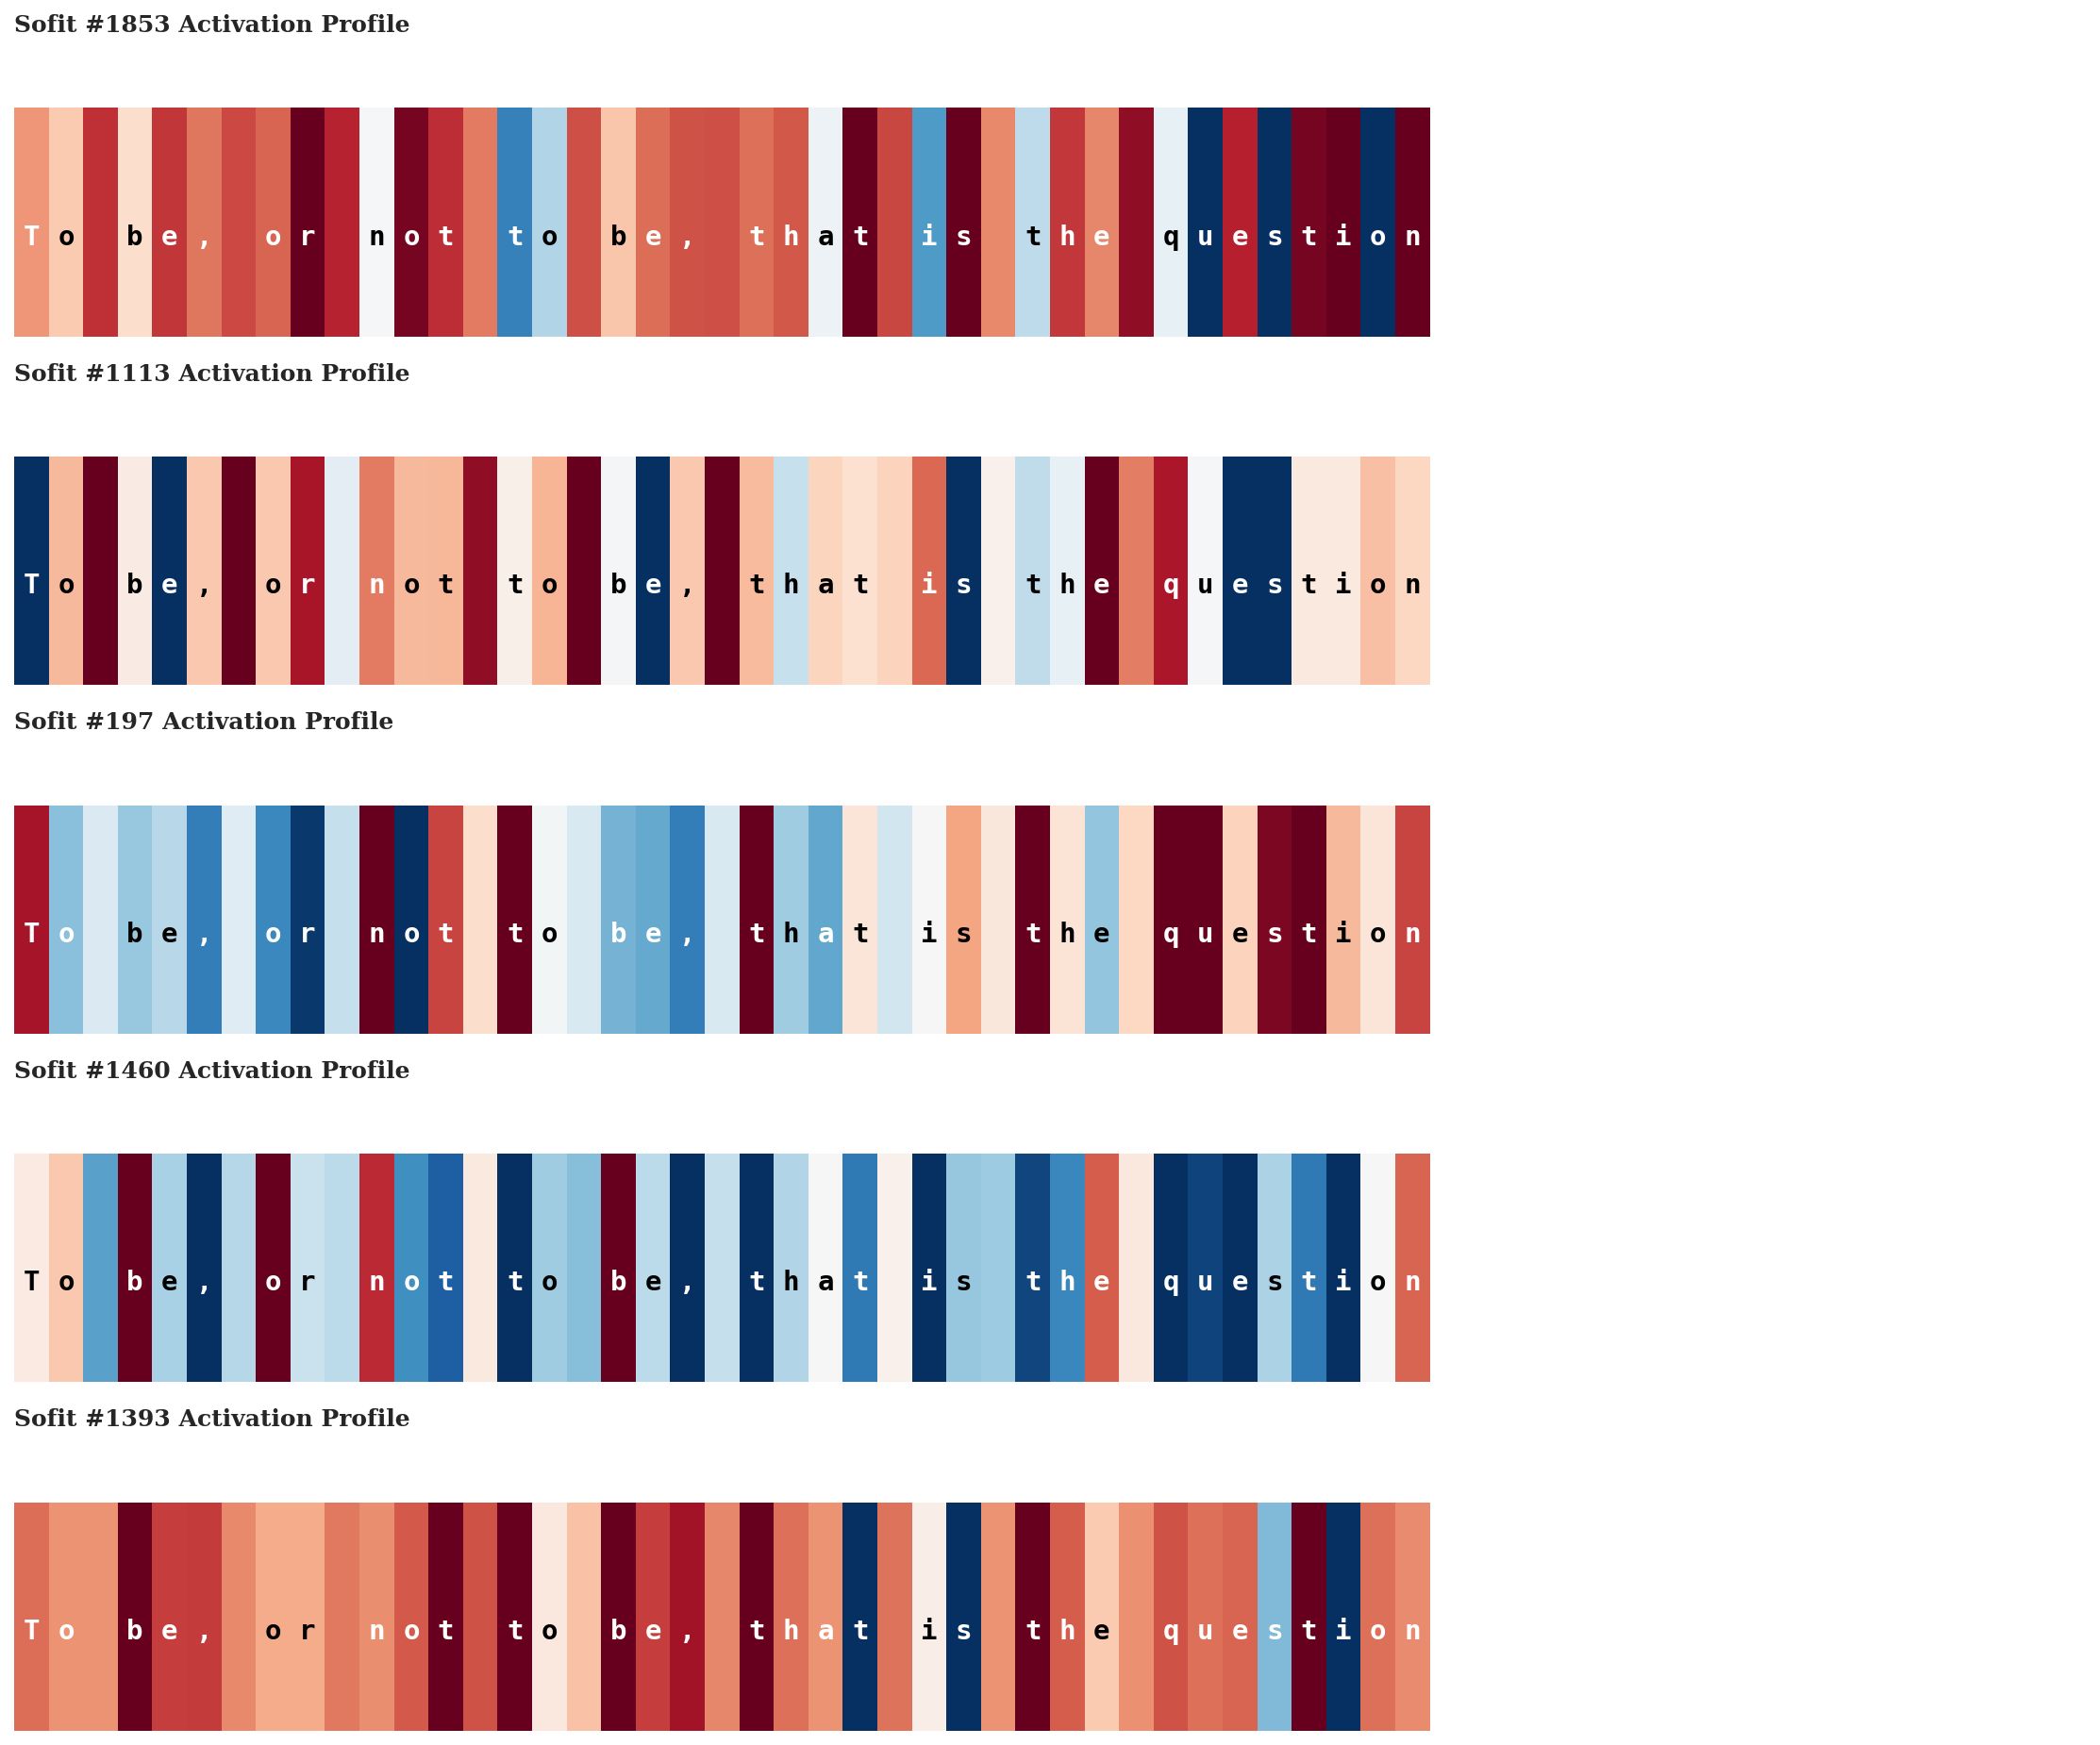

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- CONFIGURATION ---
TOP_K_SOFIT = 5  # How many interesting sofits to analyze
CMAP_NAME = 'RdBu' # Red (-1) to Blue (+1)

def analyze_sofits_triggers(model, sentence, device='cuda'):
    print(f"--- 🕵️ INTERPRETABILITY SCAN: '{sentence[:20]}...' ---")
    model.eval()

    # 1. Run the Model & Collect States
    input_ids = torch.tensor(encode(sentence), dtype=torch.long, device=device).unsqueeze(0)
    h = torch.zeros(1, model.n_sofits, device=device)

    # Shape: (Seq_Len, N_SOFITS)
    history = []

    with torch.no_grad():
        for t in range(len(sentence)):
            x = model.embed(input_ids[:, t])
            h_context = model.topology(h)
            h, _ = model.gate(h_context, x)
            history.append(h.cpu().numpy().flatten())

    history = np.array(history) # (T, N)

    # 2. Find the "Most Interesting" sofits
    # We look for sofits with high standard deviation (they toggle +1/-1 often)
    # Ignoring sofits that stay dead (0) or constant.
    variances = np.var(history, axis=0)
    top_indices = np.argsort(variances)[-TOP_K_SOFIT:][::-1] # Descending order

    print(f"Top Active sofits Found: {top_indices}")

    # 3. Visualization: "Text Highlighting"
    # We create a figure with one row per sofits

    fig, axes = plt.subplots(nrows=TOP_K_SOFIT, ncols=1, figsize=(15, 2.5 * TOP_K_SOFIT))
    if TOP_K_SOFIT == 1: axes = [axes] # Handle single case

    # Define color normalizer (-1 to 1)
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    cmap = plt.get_cmap(CMAP_NAME)

    for i, sofit_idx in enumerate(top_indices):
        ax = axes[i]
        activations = history[:, sofit_idx]

        # Turn off axis lines/ticks (we just want text)
        ax.set_axis_off()
        ax.set_title(f"Sofit #{sofit_idx} Activation Profile", loc='left',
                     fontweight='bold', fontsize=12, pad=10)

        # Render Text with Colored Backgrounds
        # We draw text character by character
        x_pos = 0.0
        y_pos = 0.5

        # We need to wrap text if it's too long, but for a simple visual
        # let's just do one long line or simple wrapping.
        # Here we use a "Monospace" grid approach for perfect alignment.

        chars_per_line = 60
        line_height = 0.2
        start_y = 1.0

        current_x = 0
        current_y = start_y

        for t, char in enumerate(sentence):
            val = activations[t]
            color = cmap(norm(val))

            # Contrast text color: White text for dark backgrounds, Black for light
            # Simple heuristic: if magnitude > 0.5, use white text
            text_color = 'white' if abs(val) > 0.4 else 'black'

            # Draw a colored box
            rect = plt.Rectangle((current_x, current_y - 0.12), 1, 0.18,
                                 facecolor=color, edgecolor='none')
            ax.add_patch(rect)

            # Draw the character
            ax.text(current_x + 0.5, current_y - 0.03, char,
                    color=text_color, ha='center', va='center',
                    family='monospace', fontsize=14, fontweight='bold')

            current_x += 1

            # Line Wrapping
            if current_x >= chars_per_line:
                current_x = 0
                current_y -= line_height

        # Adjust coordinate system for the plotted boxes
        ax.set_xlim(0, chars_per_line)
        ax.set_ylim(current_y - 0.1, start_y + 0.1)

    plt.tight_layout()
    plt.show()

# --- Usage ---
sentence = "To be, or not to be, that is the question"
analyze_sofits_triggers(model, sentence)